# Features Visualization

In this notebook, we will focus on the information contained in the original datasets. Some reviews were collected alongside additional details such as the location, date, and author. These contextual details can provide valuable insights into the personalities and habits of travelers with specific needs.

By leveraging the reviews deemed relevant, we can link them back to this metadata and obtain our first meaningful results.

In [270]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import reverse_geocoder as rg
import geopandas as gpd

In [271]:
categories = ["child", "pet", "handicap"]

In [272]:
def build_dataset_from_final_files(
    df_initial_path: str,
    df_final_path_template: str,
    categories: list[str],
) -> pl.DataFrame:
    """
    Build a merged DataFrame by:
    - loading the original full dataset (df_initial)
    - for each category:
        - load df_final file (to get ids)
        - extract all rows from df_initial with those ids
        - add a column 'category' = category_name
    - concatenate all results (ids can appear multiple times)
    """

    df_initial = pl.read_csv(df_initial_path)

    pieces = []
    for category_name in categories:

        path = df_final_path_template.format(category=category_name)

        try:
            df_final = pl.read_csv(path)
        except Exception as e:
            print(f"  -> Error reading {path}: {e}. Skipping this category.")
            continue

        # Extract ids
        ids = df_final["id"].unique().to_list()

        # Filter original dataset
        df_cat = df_initial.filter(pl.col("id").is_in(ids))

        # Add the category column
        df_cat = df_cat.with_columns(
            pl.lit(category_name).alias("category")
        )

        # Append segment
        pieces.append(df_cat)
        print(f"  -> Added {df_cat.shape[0]} rows for category '{category_name}'")

    # Concatenate everything
    if not pieces:
        print("No pieces collected — returning empty DataFrame")
        return pl.DataFrame()

    df_merged = pl.concat(pieces, how="vertical")
    print(f"\nFinal merged DataFrame: {df_merged.shape[0]} rows, {df_merged.shape[1]} cols")

    return df_merged


## Booking

The first step is to retrieve from the initial dataset only the lines corresponding to the reviews relevant to our study.

In [273]:
df_initial_path = "../../data/original/dataset/data_booking.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_booking_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 224 rows for category 'child'
  -> Added 108 rows for category 'pet'
  -> Added 79 rows for category 'handicap'

Final merged DataFrame: 411 rows, 18 cols


### Guest type

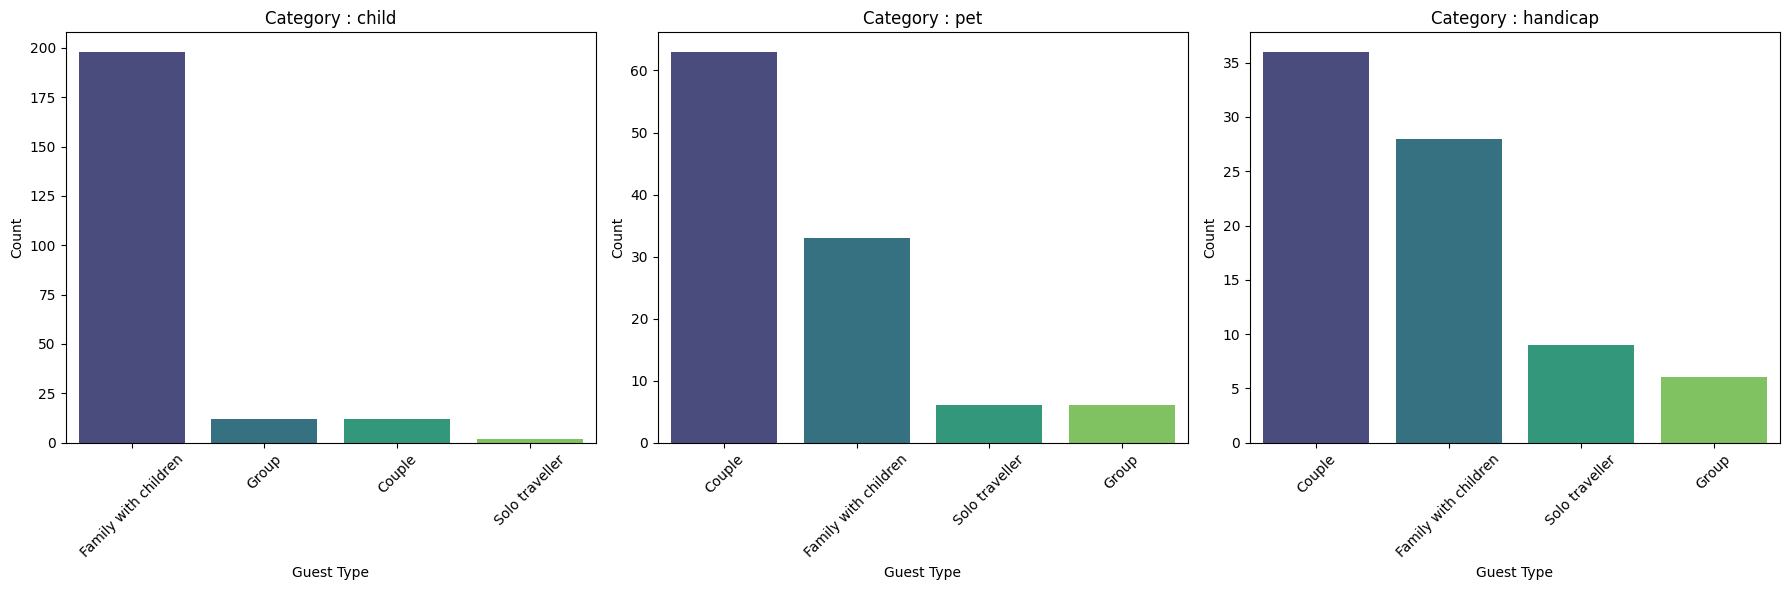

In [274]:
feature = "guest_type"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))

    types = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category : {cat}")
    ax.set_xlabel("Guest Type")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Accommodation type

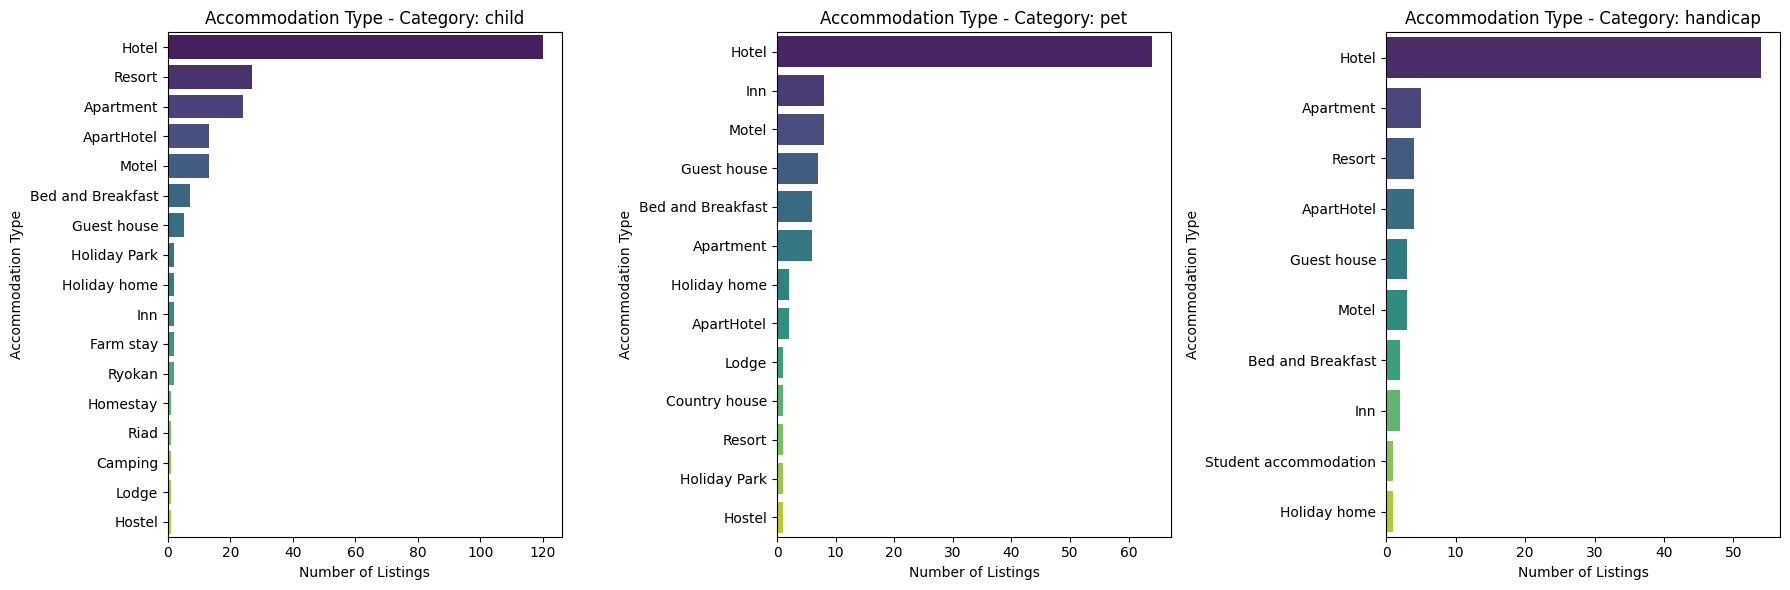

In [275]:
feature = "accommodation_type"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))
    
    types = counts[feature].to_list()
    values = counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=values, y=types, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Accommodation Type - Category: {cat}")
    ax.set_xlabel("Number of Listings")
    ax.set_ylabel("Accommodation Type")

plt.tight_layout()
plt.show()

### Months of travel

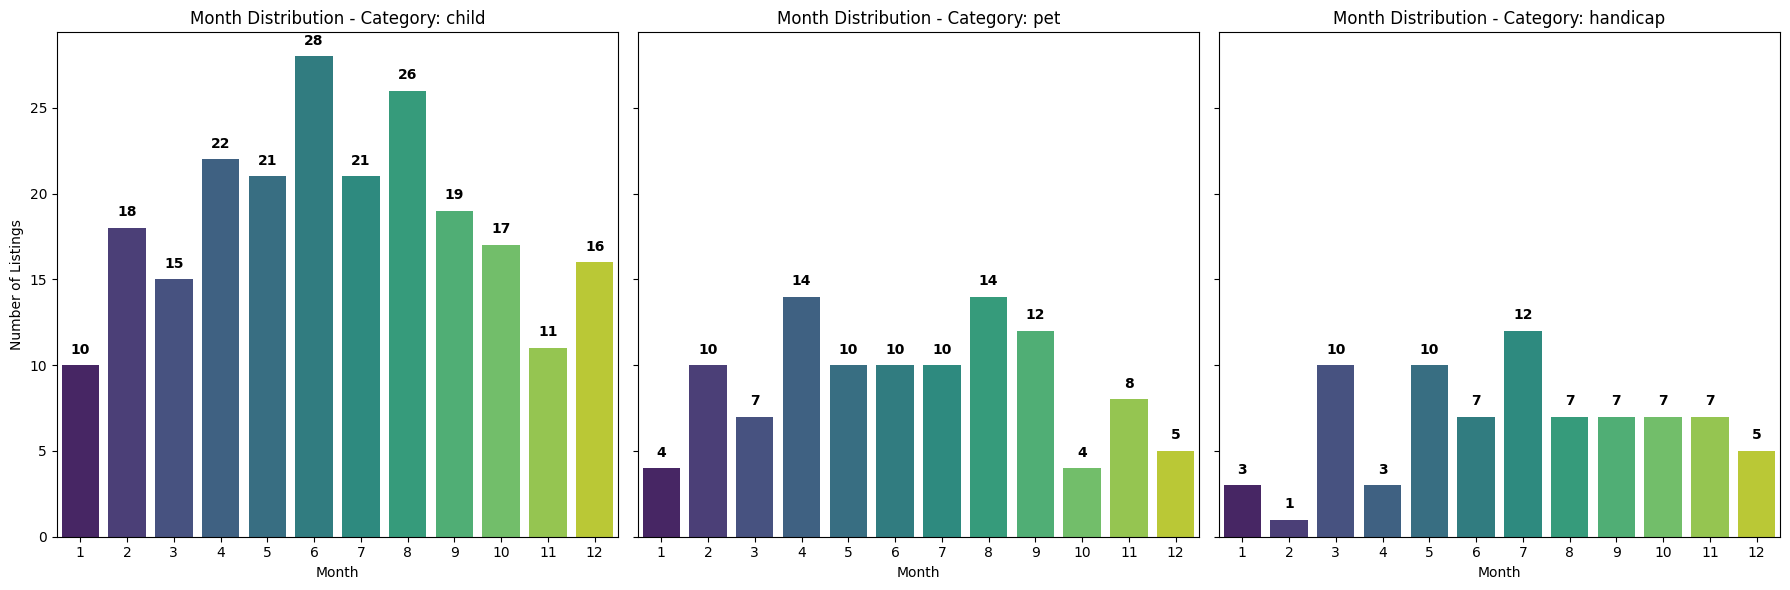

In [276]:
feature = "month"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature))
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    # Add values on top of bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Countries of travel

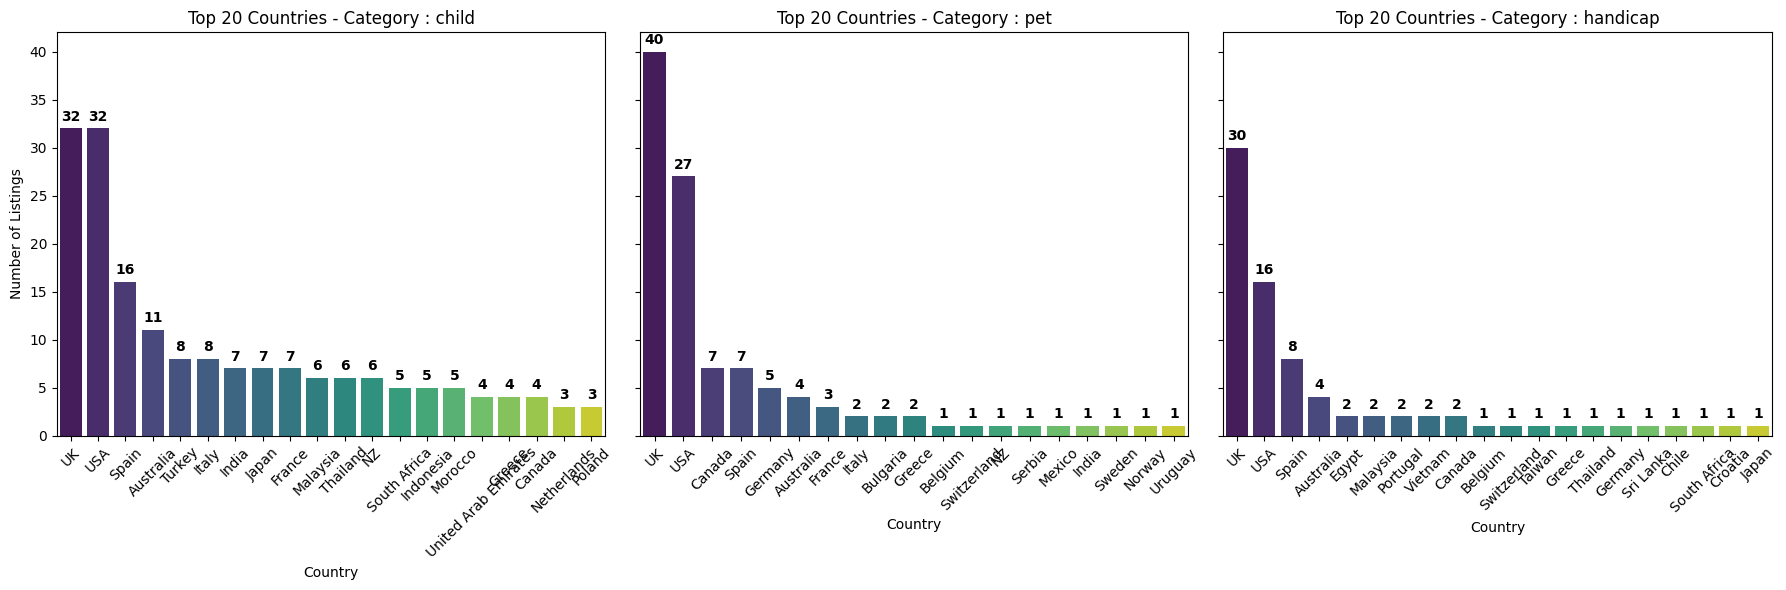

In [277]:
feature = "accommodation_country"

country_map = {
    "United Kingdom": "UK",
    "United States of America": "USA",
    "New Zealand": "NZ"
}

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True)
    
    top20 = counts.head(20)
    countries = [country_map.get(c, c) for c in top20[feature].to_list()]
    values = top20["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(countries))
    sns.barplot(x=countries, y=values, hue=countries, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top 20 Countries - Category : {cat}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Listings")
    ax.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Hotel Reviews 1

In [278]:
df_initial_path = "../../data/original/dataset/data_hotel_reviews_1.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_hotel_reviews_1_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 93 rows for category 'child'
  -> Added 61 rows for category 'pet'
  -> Added 46 rows for category 'handicap'

Final merged DataFrame: 200 rows, 21 cols


### Type of accommodation

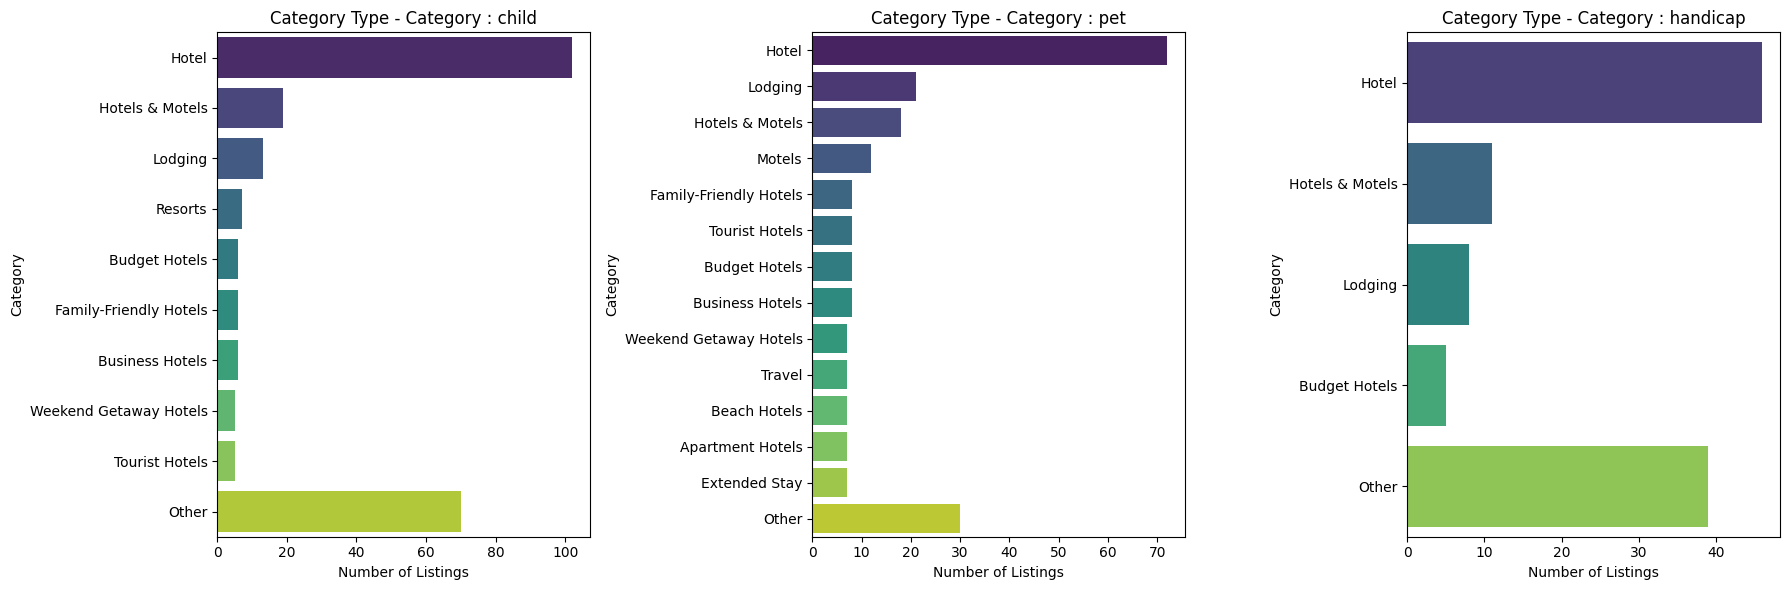

In [279]:
min_other = 5

merge_map = {
    "Hotel": "Hotel",
    "Hotels": "Hotel"
}

df_expanded = (
    df
    .with_columns(pl.col("categories").str.split(",").alias("categories_split"))
    .explode("categories_split")             
    .with_columns(pl.col("categories_split").str.strip_chars().alias("categories_clean"))
)

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_expanded.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(pl.col("categories_clean").map_elements(lambda x: merge_map.get(x, x)).alias("categories_display"))
    
    counts = (
        df_display.group_by("categories_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "categories_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])

    types = frequent_counts["categories_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=values, y=types, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category Type - Category : {cat}")
    ax.set_xlabel("Number of Listings")
    ax.set_ylabel("Category")

plt.tight_layout()
plt.show()


### Countries of travel

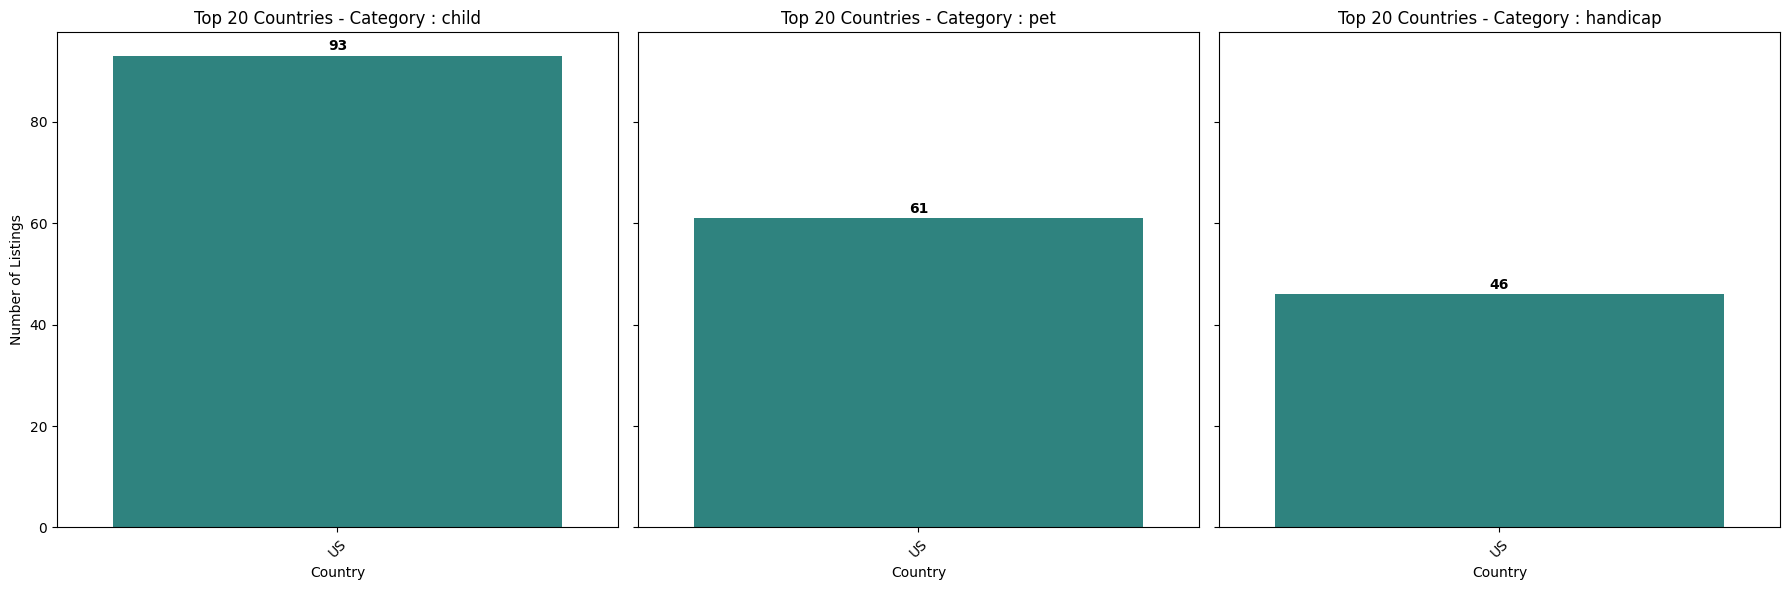

In [280]:
feature = "country"

country_map = {
    "United Kingdom": "UK",
    "United States of America": "USA",
    "New Zealand": "NZ"
}

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True)
    
    top20 = counts.head(20)
    countries = [country_map.get(c, c) for c in top20[feature].to_list()]
    values = top20["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(countries))
    sns.barplot(x=countries, y=values, hue=countries, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top 20 Countries - Category : {cat}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Listings")
    ax.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Date

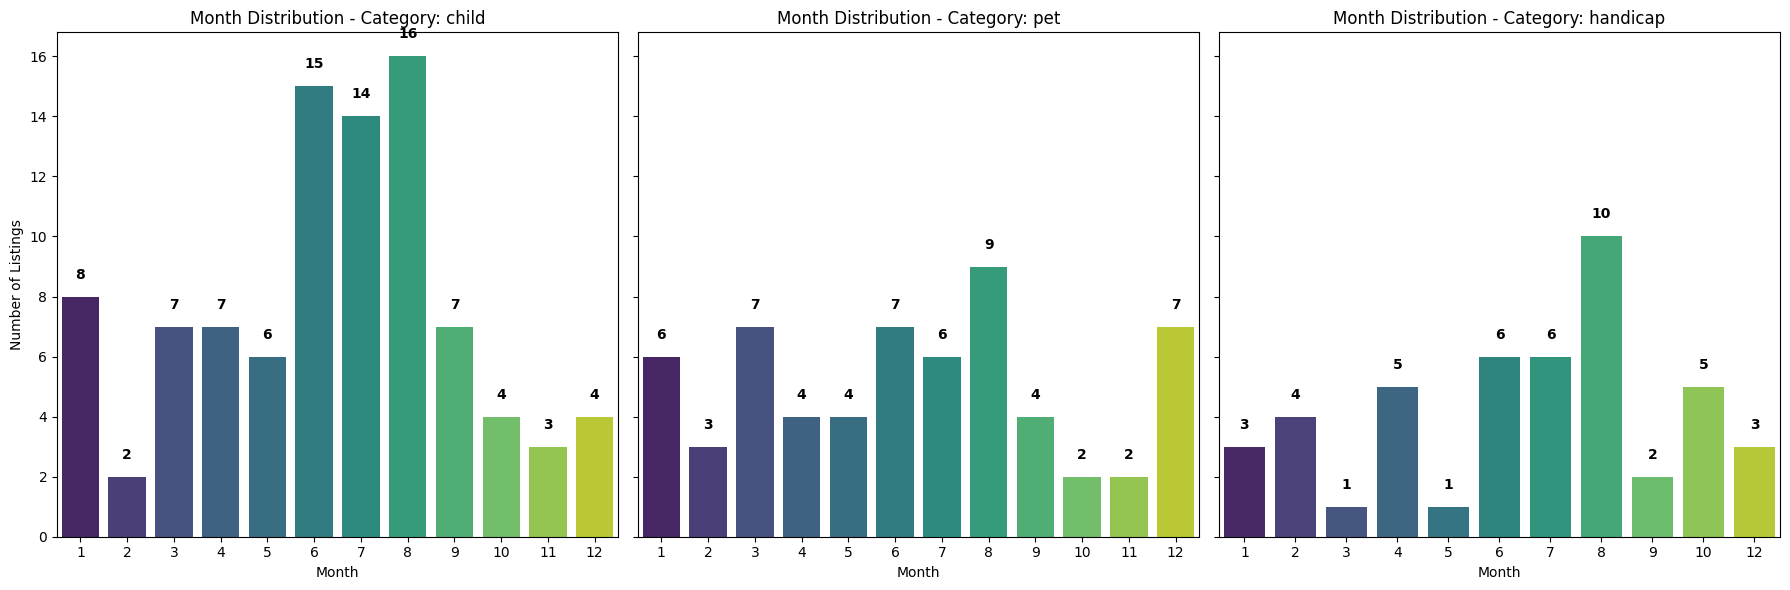

In [281]:
df = df.with_columns(pl.col("reviews.date").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ").alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature)
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Hotel Reviews 2

In [282]:
df_initial_path = "../../data/original/dataset/data_hotel_reviews_2.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_hotel_reviews_2_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 51 rows for category 'child'
  -> Added 58 rows for category 'pet'
  -> Added 45 rows for category 'handicap'

Final merged DataFrame: 154 rows, 27 cols


### Type of accommodation

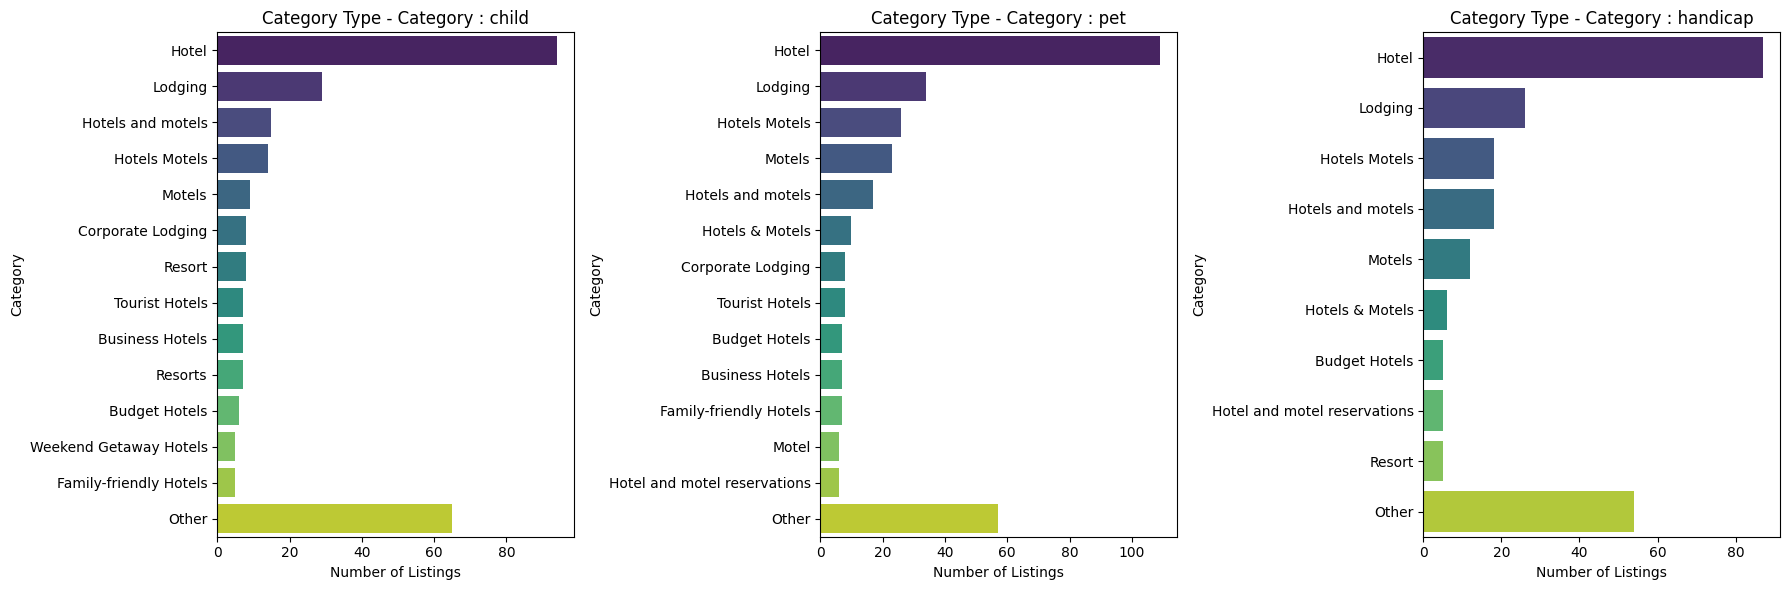

In [283]:
min_other = 5

merge_map = {
    "Hotel": "Hotel",
    "Hotels": "Hotel"
}

df_expanded = (
    df
    .with_columns(pl.col("categories").str.split(",").alias("categories_split"))
    .explode("categories_split")             
    .with_columns(pl.col("categories_split").str.strip_chars().alias("categories_clean"))
)

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_expanded.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(pl.col("categories_clean").map_elements(lambda x: merge_map.get(x, x)).alias("categories_display"))
    
    counts = (
        df_display.group_by("categories_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "categories_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])

    types = frequent_counts["categories_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=values, y=types, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category Type - Category : {cat}")
    ax.set_xlabel("Number of Listings")
    ax.set_ylabel("Category")

plt.tight_layout()
plt.show()


### Countries of travel

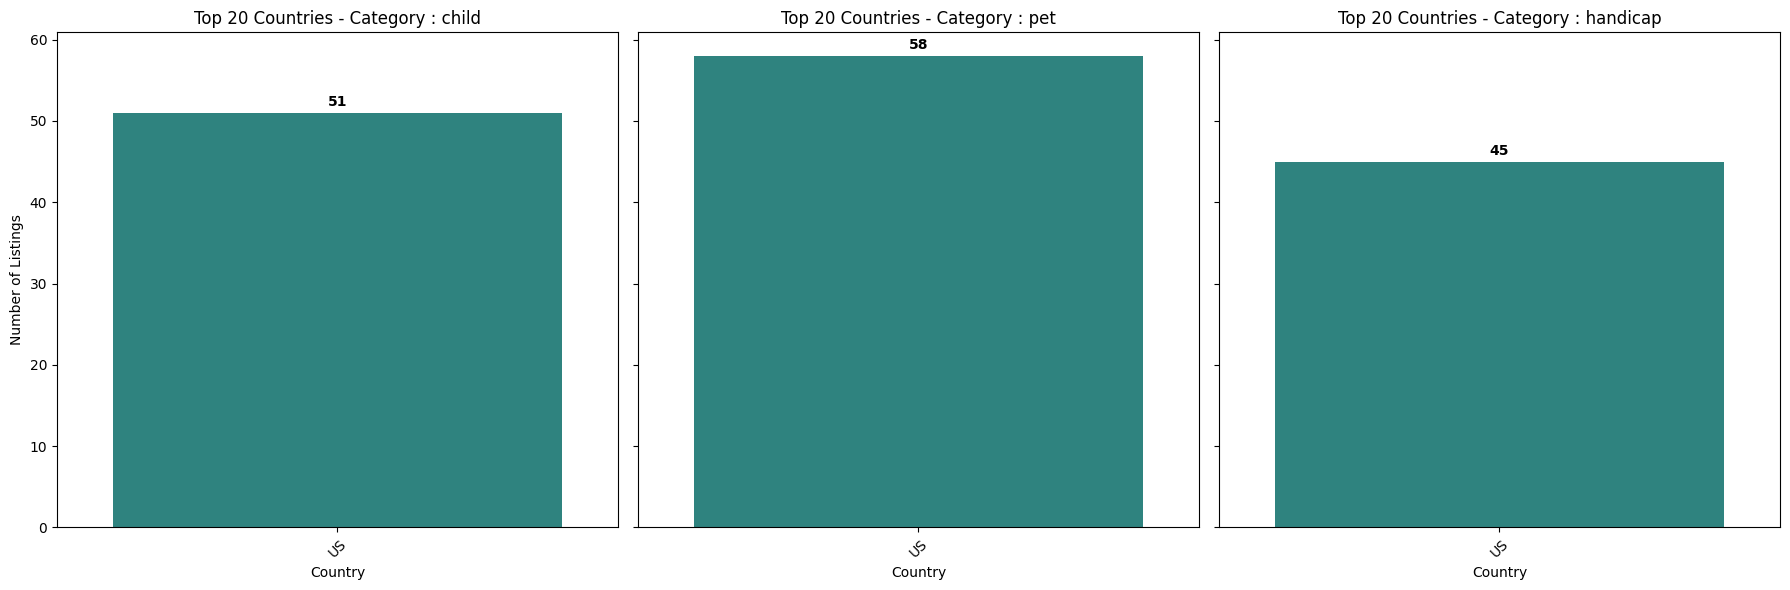

In [284]:
feature = "country"

country_map = {
    "United Kingdom": "UK",
    "United States of America": "USA",
    "New Zealand": "NZ"
}

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True)
    
    top20 = counts.head(20)
    countries = [country_map.get(c, c) for c in top20[feature].to_list()]
    values = top20["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(countries))
    sns.barplot(x=countries, y=values, hue=countries, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top 20 Countries - Category : {cat}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Listings")
    ax.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Date

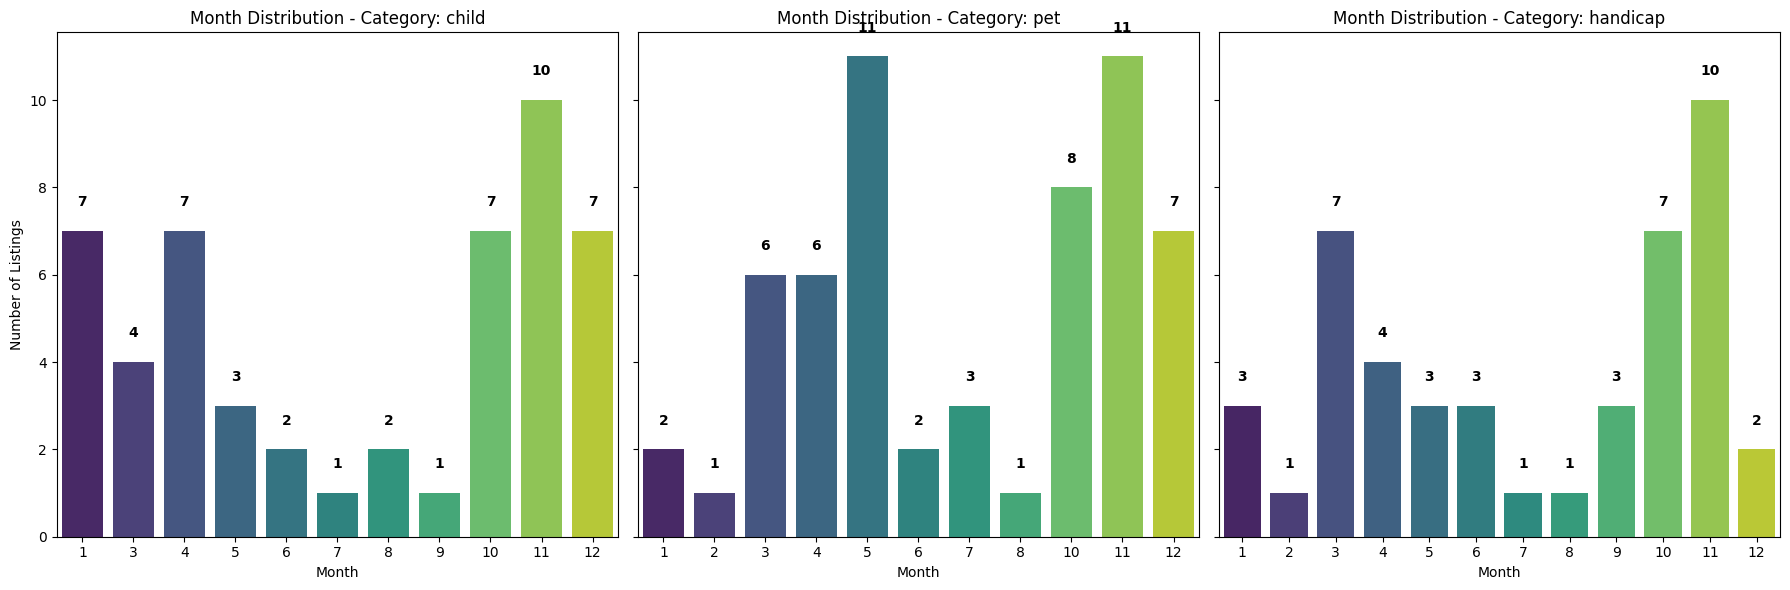

In [285]:
df = df.with_columns(pl.col("dateAdded").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ").alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature)
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Hotel Reviews 3

In [286]:
df_initial_path = "../../data/original/dataset/data_hotel_reviews_3.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_hotel_reviews_3_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 29 rows for category 'child'
  -> Added 66 rows for category 'pet'
  -> Added 49 rows for category 'handicap'

Final merged DataFrame: 144 rows, 27 cols


### Type of accommodation

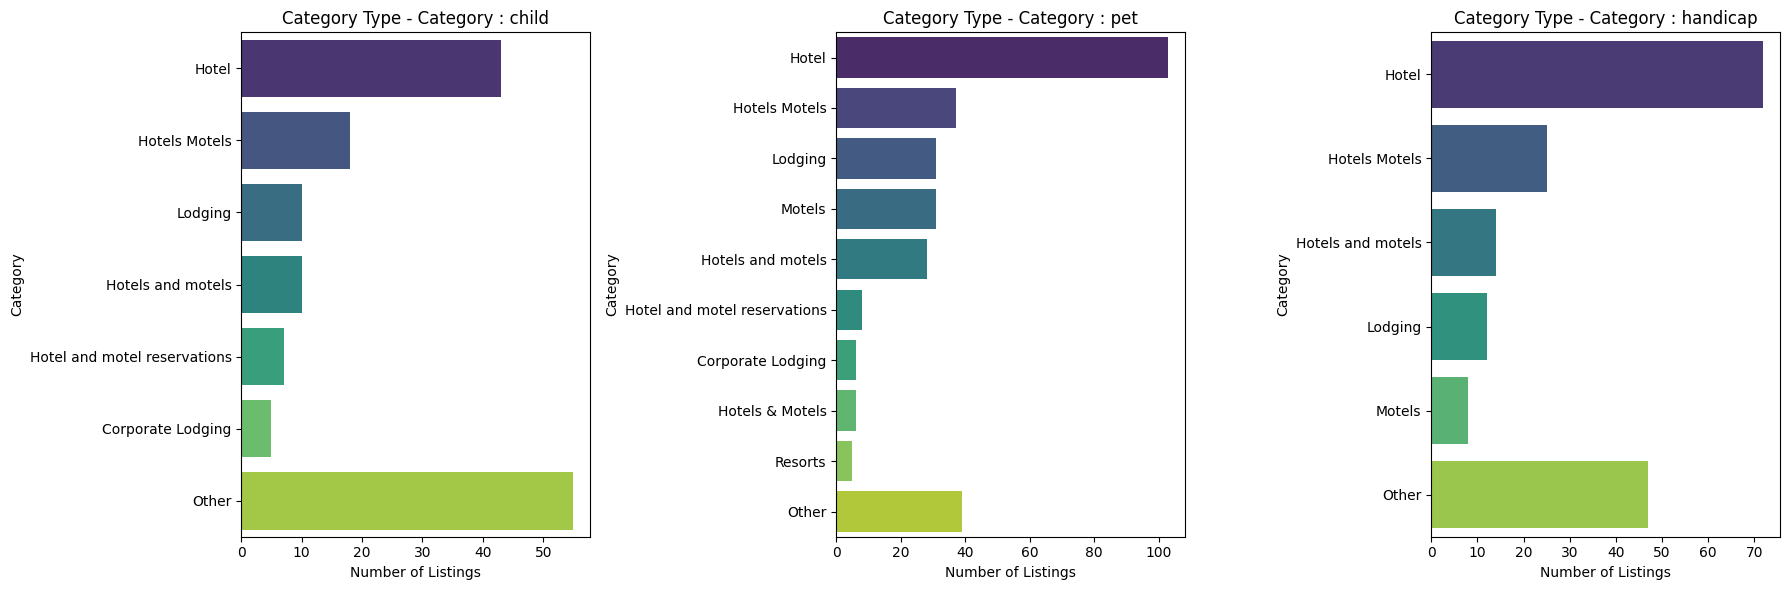

In [287]:
min_other = 5

merge_map = {
    "Hotel": "Hotel",
    "Hotels": "Hotel"
}

df_expanded = (
    df
    .with_columns(pl.col("categories").str.split(",").alias("categories_split"))
    .explode("categories_split")             
    .with_columns(pl.col("categories_split").str.strip_chars().alias("categories_clean"))
)

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_expanded.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(pl.col("categories_clean").map_elements(lambda x: merge_map.get(x, x)).alias("categories_display"))
    
    counts = (
        df_display.group_by("categories_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "categories_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])

    types = frequent_counts["categories_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=values, y=types, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category Type - Category : {cat}")
    ax.set_xlabel("Number of Listings")
    ax.set_ylabel("Category")

plt.tight_layout()
plt.show()


### Countries of travel

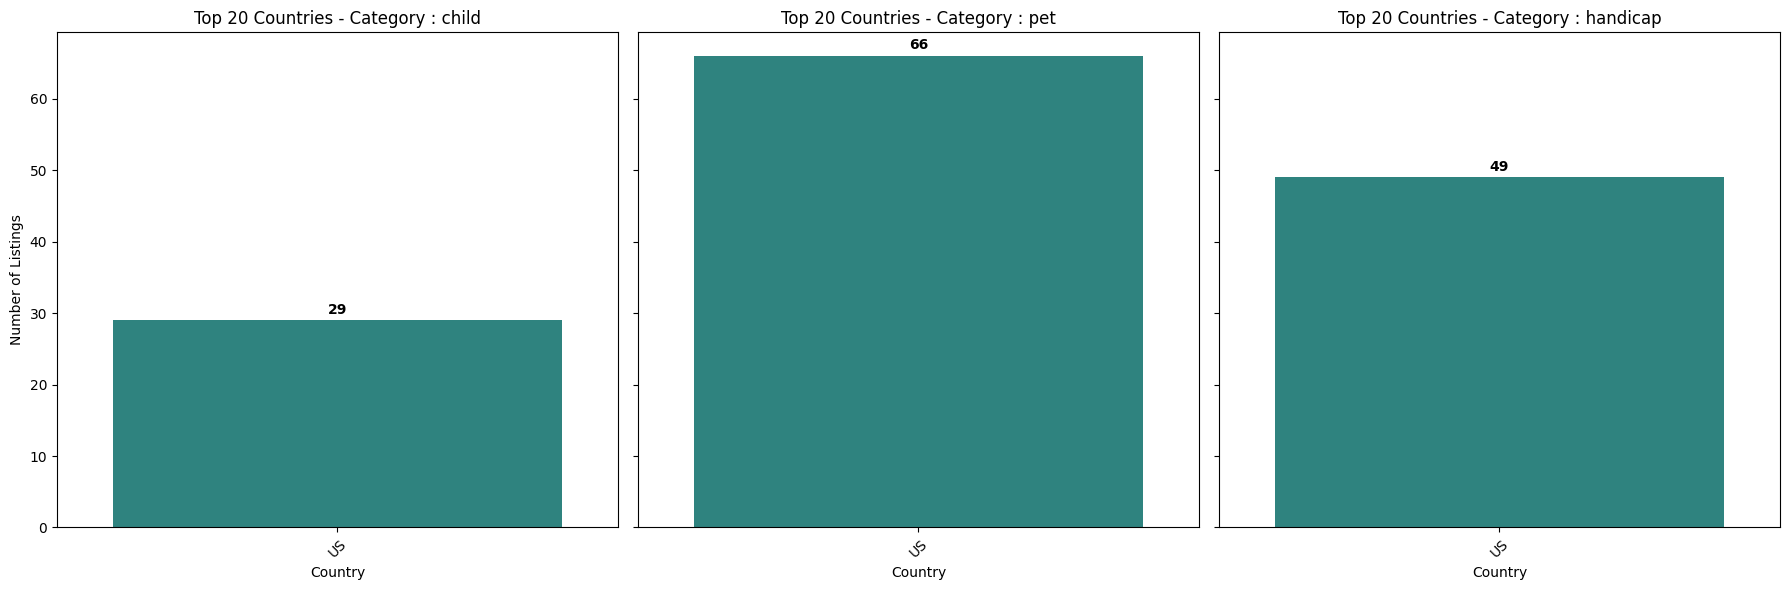

In [288]:
feature = "country"

country_map = {
    "United Kingdom": "UK",
    "United States of America": "USA",
    "New Zealand": "NZ"
}

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True)
    
    top20 = counts.head(20)
    countries = [country_map.get(c, c) for c in top20[feature].to_list()]
    values = top20["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(countries))
    sns.barplot(x=countries, y=values, hue=countries, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top 20 Countries - Category : {cat}")
    ax.set_xlabel("Country")
    ax.set_ylabel("Number of Listings")
    ax.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Date

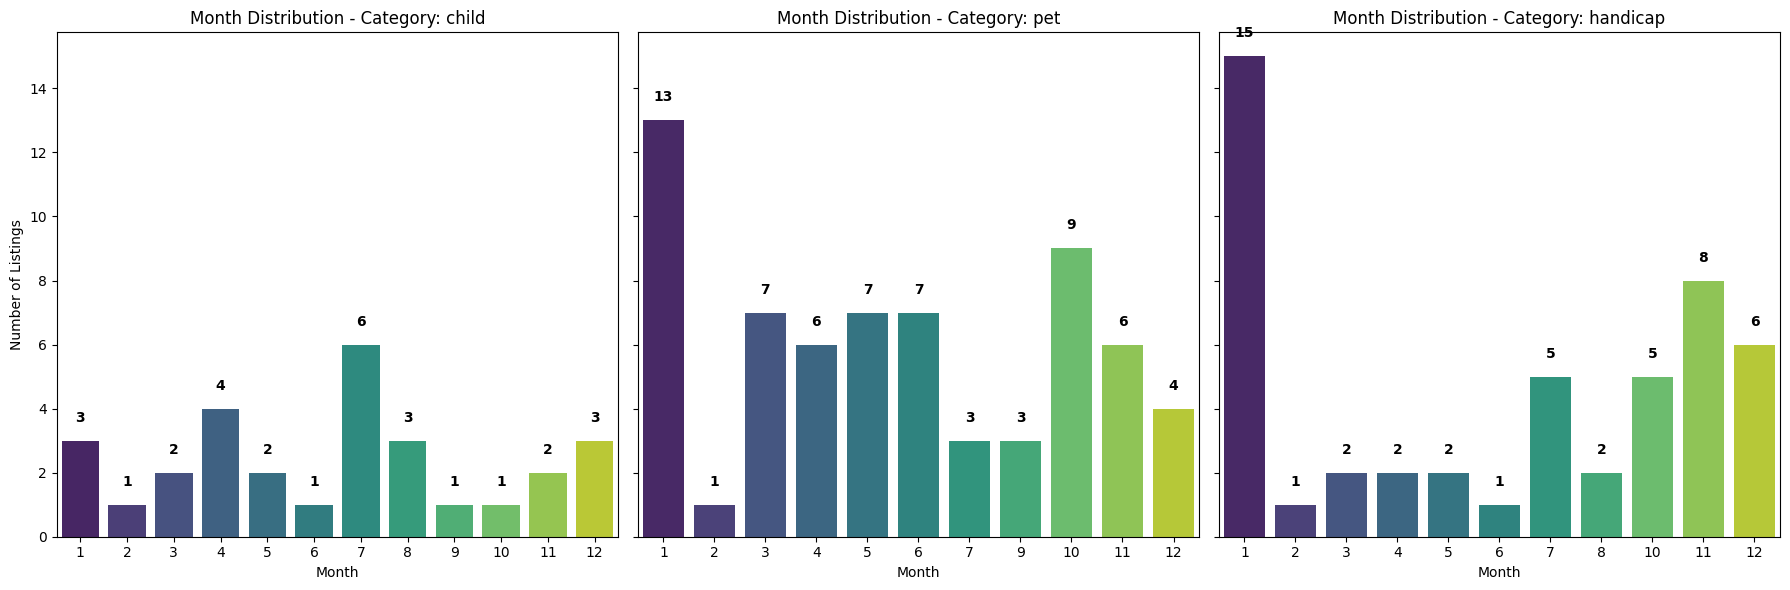

In [289]:
df = df.with_columns(pl.col("dateAdded").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ").alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature)
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## TripAdvisor

In [290]:
df_initial_path = "../../data/original/dataset/data_tripadvisor_hotel_reviews.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_tripadvisor_hotel_reviews_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Error reading ../../data/processed/final/child/validated_data_tripadvisor_hotel_reviews_child_good.csv: Le fichier spécifié est introuvable. (os error 2): ../../data/processed/final/child/validated_data_tripadvisor_hotel_reviews_child_good.csv. Skipping this category.
  -> Error reading ../../data/processed/final/pet/validated_data_tripadvisor_hotel_reviews_pet_good.csv: Le fichier spécifié est introuvable. (os error 2): ../../data/processed/final/pet/validated_data_tripadvisor_hotel_reviews_pet_good.csv. Skipping this category.
  -> Error reading ../../data/processed/final/handicap/validated_data_tripadvisor_hotel_reviews_handicap_good.csv: Le fichier spécifié est introuvable. (os error 2): ...data/processed/final/handicap/validated_data_tripadvisor_hotel_reviews_handicap_good.csv (set POLARS_VERBOSE=1 to see full path). Skipping this category.
No pieces collected — returning empty DataFrame


## Airline Reviews 1

In [291]:
df_initial_path = "../../data/original/dataset/data_airline_reviews_1.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_airline_reviews_1_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 52 rows for category 'child'
  -> Error reading ../../data/processed/final/pet/validated_data_airline_reviews_1_pet_good.csv: Le fichier spécifié est introuvable. (os error 2): ../../data/processed/final/pet/validated_data_airline_reviews_1_pet_good.csv. Skipping this category.
  -> Added 34 rows for category 'handicap'

Final merged DataFrame: 86 rows, 21 cols


### Date of flown

C:\Users\emma\AppData\Local\Temp\ipykernel_2536\3014484413.py:16: UserWarning: The palette list has more values (13) than needed (12), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\3014484413.py:16: UserWarning: The palette list has more values (12) than needed (11), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)


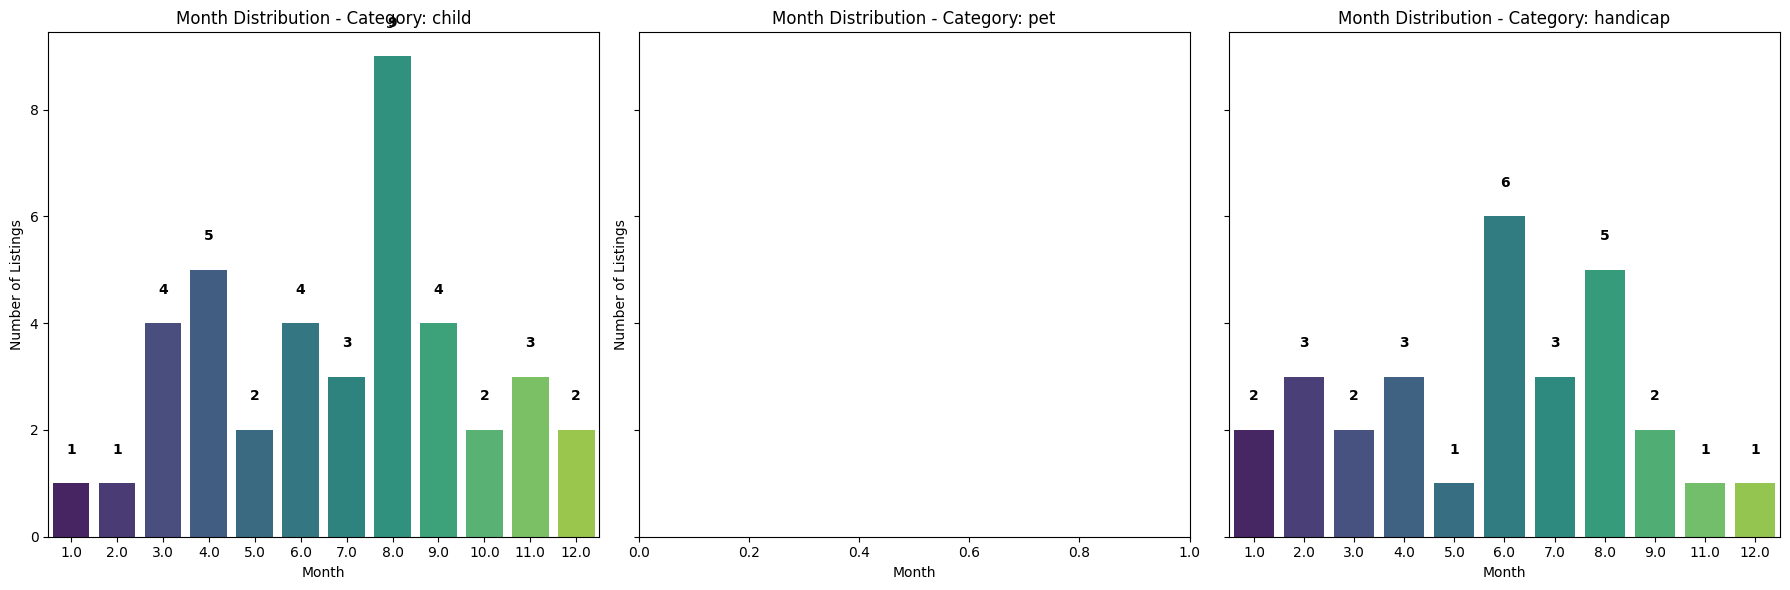

In [292]:
df = df.with_columns(pl.col("DateFlown").str.strptime(pl.Date, format="%B %Y", strict=False).alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature)
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    n_bars = len(values)
    palette = sns.color_palette("viridis", n_colors=n_bars)
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Type of Traveller

C:\Users\emma\AppData\Local\Temp\ipykernel_2536\1956144772.py:13: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\1956144772.py:13: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)


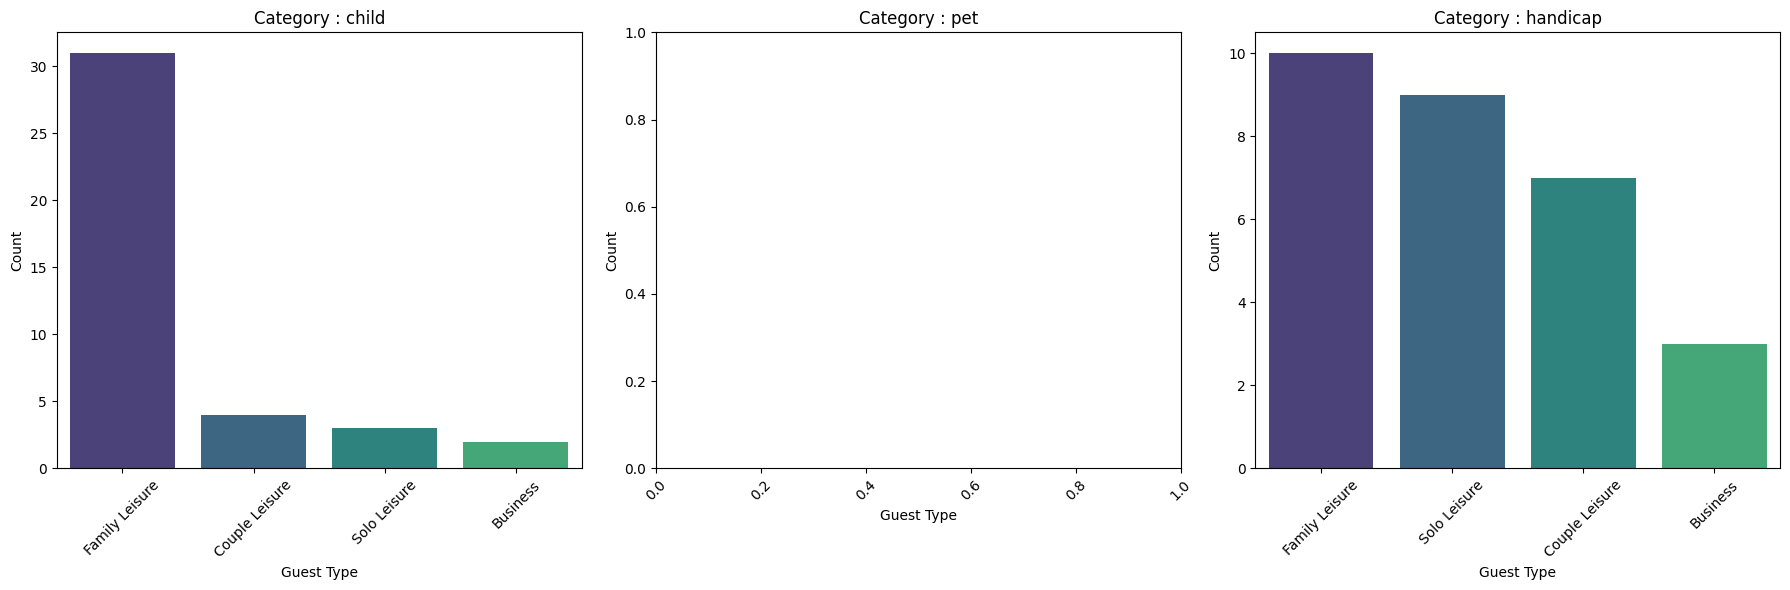

In [293]:
feature = "TypeOfTraveller"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))

    types = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category : {cat}")
    ax.set_xlabel("Guest Type")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Route

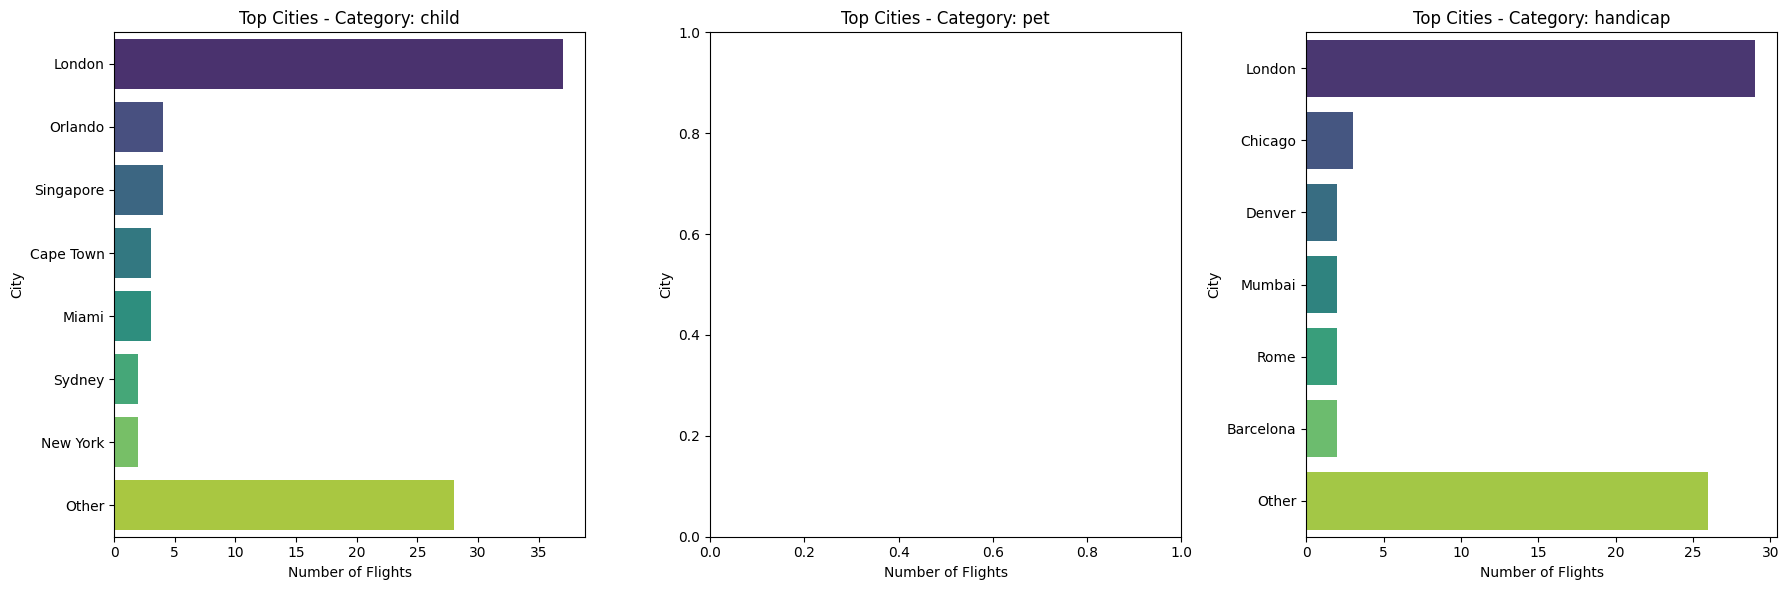

In [294]:
min_other = 2

def extract_cities(route: str):
    if route is None:
        return []
    parts = route.split(" to ")
    cities = []
    for part in parts:
        subparts = part.split(" via ")
        cities.extend([s.strip() for s in subparts])
    return cities

df_routes = (
    df
    .filter(pl.col("Route").is_not_null())
    .with_columns(
        pl.col("Route")
        .map_elements(extract_cities, return_dtype=pl.List(pl.Utf8))
        .alias("cities_split")
    )
    .explode("cities_split")
)

merge_map = {
    "London Heathrow": "London",
    "London Gatwick": "London",
    "Heathrow": "London",
    "LGW": "London",
    "LHR": "London",
    "New York JFK": "New York",
    "NYC": "New York",
    "New York": "New York",
    "JFK": "New York",
    "PHL": "Philadelphia", 
    "MIA": "Miami",
    "Miami": "Miami",
    "Orlando MCO": "Orlando",
    "Orlando": "Orlando",
    "MCO": "Orlando",
    "SIN": "Singapore",
    "Singapore": "Singapore",
    "SYD": "Sydney",
    "Sydney": "Sydney",
    "Boston": "Boston",
    "Cairo": "Cairo",
    "Algiers": "Algiers",
    "Gatwick": "London",  
    "Venice": "Venice",
    "Warsaw": "Warsaw",
    "Moscow": "Moscow",
    "Lahore": "Lahore",
    "Delhi": "Delhi",
    "Chennai": "Chennai",
    "Olbia": "Olbia",
    "Gibraltar": "Gibraltar",
    "Budapest": "Budapest",
    "Mahon": "Mahon",
    "Dubai": "Dubai",
    "Cape Town": "Cape Town",
    "Madeira": "Madeira",
    "Alicante": "Alicante",
    "Bergen": "Bergen",
    "Nice": "Nice",
    "PRG": "Prague",
    "PHL": "Philadelphia",
    "AMS": "Amsterdam",
    "BCN": "Barcelona",
    "MCO": "Orlando",
    "IST": "Istanbul",
    "BUD": "Budapest",
    "AGP": "Malaga",
    "MCI": "Kansas City",
    "CDG": "Paris",
    "GIG": "Rio de Janeiro",
    "Denver": "Denver",
    "Frankfurt": "Frankfurt",
    "Mumbai": "Mumbai",
    "Madrid": "Madrid",
    "SÃ£o Paulo": "Sao Paulo",
    "Milan": "Milan",
    "Munich": "Munich",
    "Seattle": "Seattle",
    "Calgary": "Calgary",
    "DÃ¼sseldorf": "Dusseldorf",
    "Seychelles": "Seychelles",
    "Tampa": "Tampa",
    "Brussels": "Brussels",
    "San Diego": "San Diego",
    "ATH": "Athens",
    "GLA": "Glasgow",
    "Rome": "Rome",
    "Pisa": "Pisa",
    "HKG": "Hong Kong",
    "ORD": "Chicago",
    "YVR": "Vancouver",
    "SSH": "Sharm El Sheikh",
    "MEL": "Melbourne",
    "SFO": "San Francisco",
    "DXB": "Dubai",
    "HYD": "Hyderabad"
}


fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_routes.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(
        pl.col("cities_split").map_elements(lambda x: merge_map.get(x, x)).alias("cities_display")
    )
    
    counts = (
        df_display.group_by("cities_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "cities_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])
    
    cities = frequent_counts["cities_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(cities))
    sns.barplot(x=values, y=cities, hue=cities, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top Cities - Category: {cat}")
    ax.set_xlabel("Number of Flights")
    ax.set_ylabel("City")

plt.tight_layout()
plt.show()

### Class

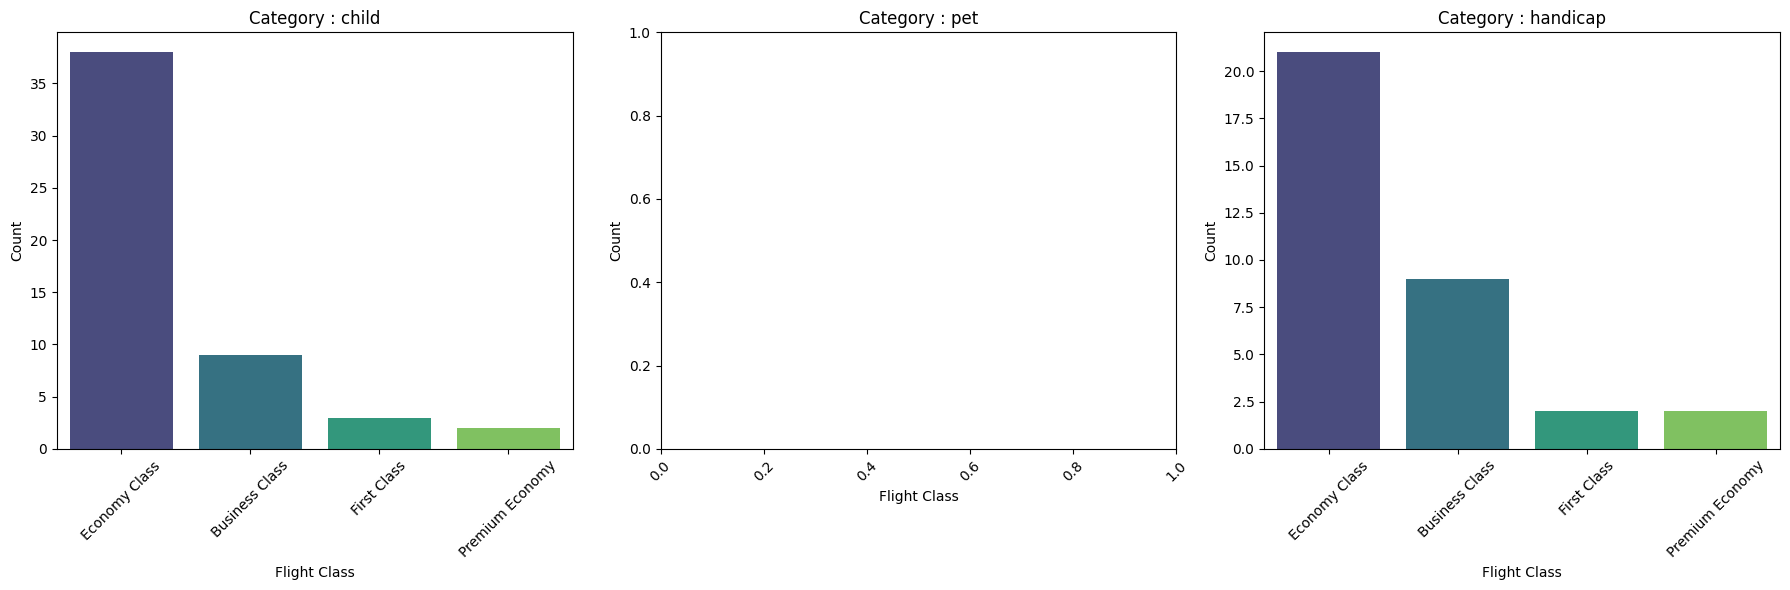

In [295]:
feature = "SeatType"   

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))

    types = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category : {cat}")
    ax.set_xlabel("Flight Class")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Airline Reviews 2

In [296]:
df_initial_path = "../../data/original/dataset/data_airline_reviews_2.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_airline_reviews_2_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 76 rows for category 'child'
  -> Added 8 rows for category 'pet'
  -> Added 78 rows for category 'handicap'

Final merged DataFrame: 162 rows, 19 cols


In [297]:
print(df["Month Flown"])

shape: (162,)
Series: 'Month Flown' [str]
[
	"November 2023"
	"May 2023"
	"May 2022"
	"December 2019"
	"June 2019"
	…
	"October 2017"
	"November 2016"
	"November 2016"
	"March 2023"
	"March 2023"
]


### Date of Flown

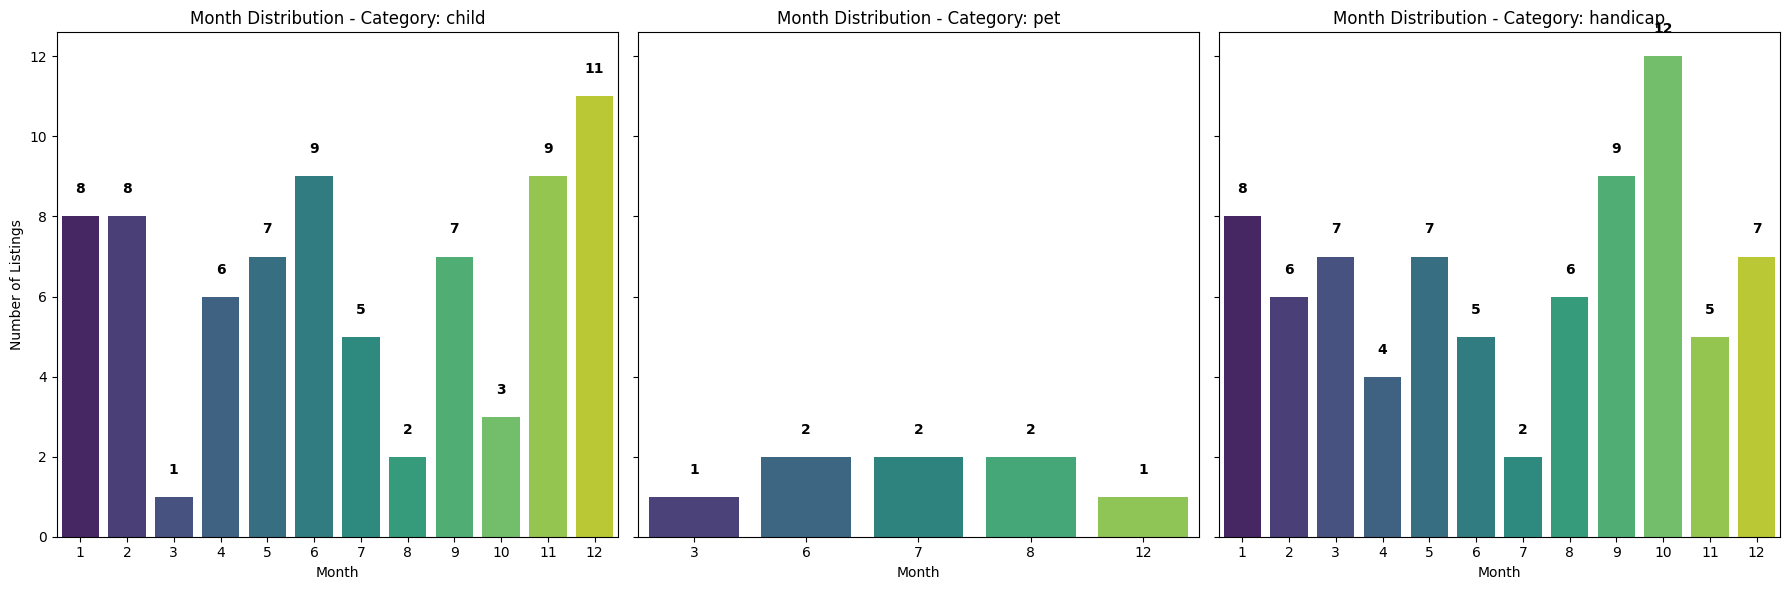

In [298]:
df = df.with_columns(pl.col("Month Flown").str.strptime(pl.Date, format="%B %Y", strict=False).alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature)
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()
    
    n_bars = len(values)
    palette = sns.color_palette("viridis", n_colors=n_bars)
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


### Type of Traveler

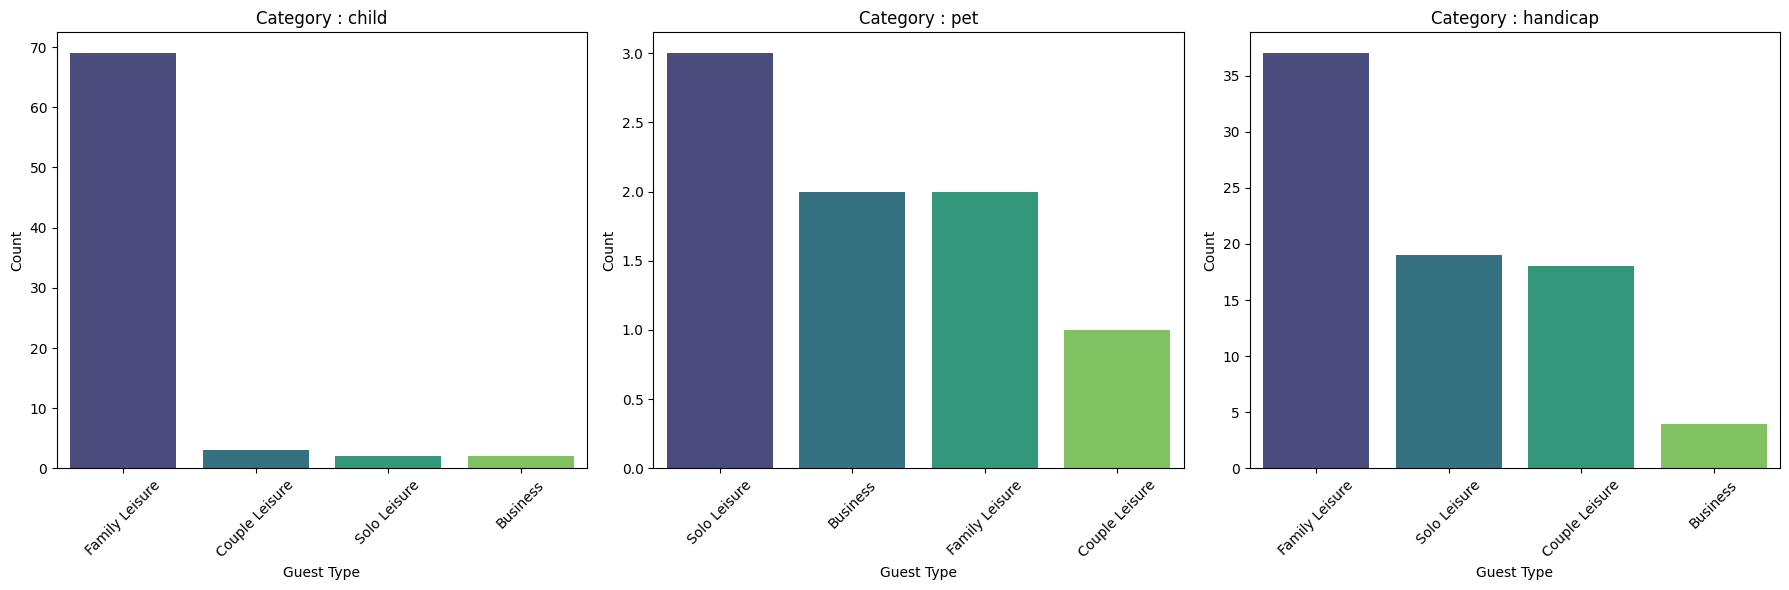

In [299]:
feature = "Type of Traveller"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))

for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))

    types = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category : {cat}")
    ax.set_xlabel("Guest Type")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Route

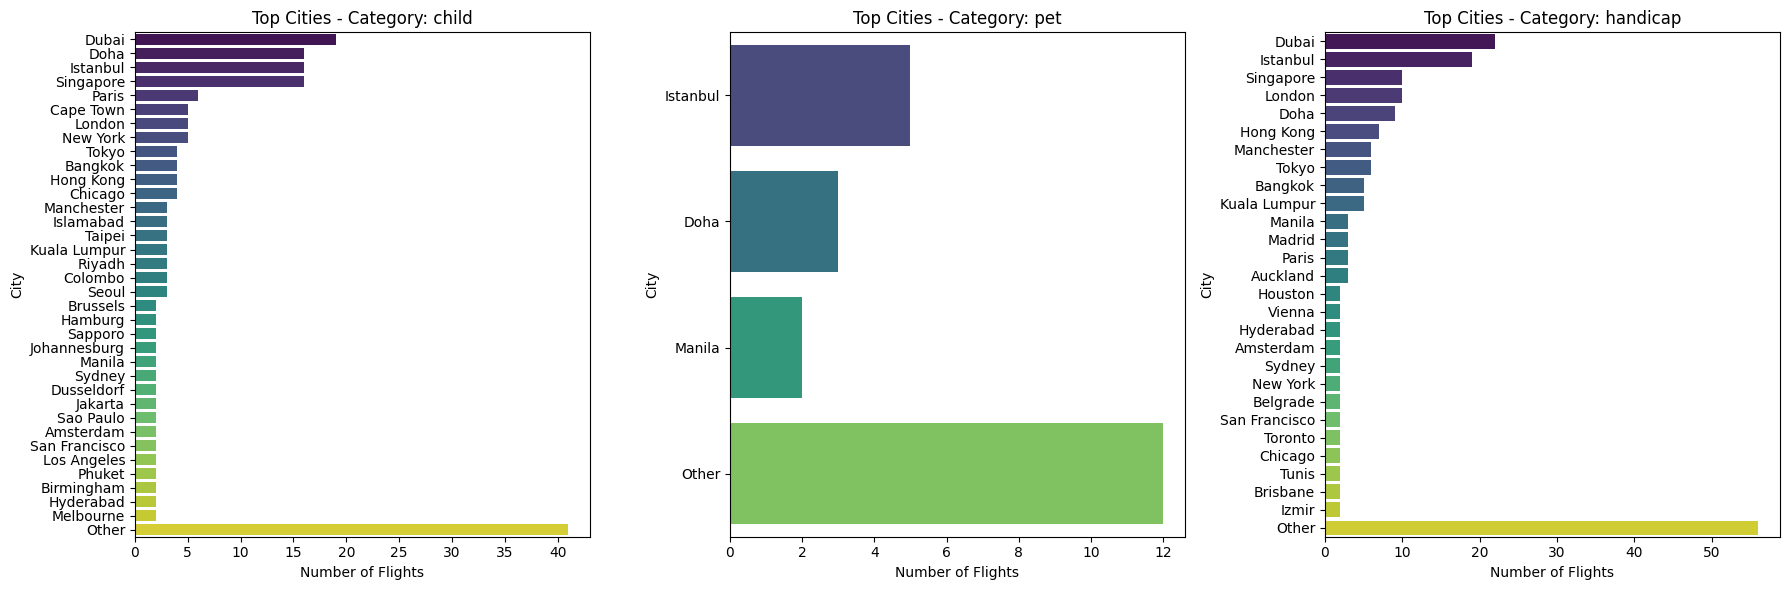

In [300]:
min_other = 2

def extract_cities(route: str):
    if route is None:
        return []
    parts = route.split(" to ")
    cities = []
    for part in parts:
        subparts = part.split(" via ")
        cities.extend([s.strip() for s in subparts])
    return cities

df_routes = (
    df
    .filter(pl.col("Route").is_not_null())
    .with_columns(
        pl.col("Route")
        .map_elements(extract_cities, return_dtype=pl.List(pl.Utf8))
        .alias("cities_split")
    )
    .explode("cities_split")
)

merge_map = {
    "London Heathrow": "London",
    "London Gatwick": "London",
    "Heathrow": "London",
    "LGW": "London",
    "LHR": "London",
    "New York JFK": "New York",
    "NYC": "New York",
    "New York": "New York",
    "JFK": "New York",
    "PHL": "Philadelphia", 
    "MIA": "Miami",
    "Miami": "Miami",
    "Orlando MCO": "Orlando",
    "Orlando": "Orlando",
    "MCO": "Orlando",
    "SIN": "Singapore",
    "Singapore": "Singapore",
    "SYD": "Sydney",
    "Sydney": "Sydney",
    "Boston": "Boston",
    "Cairo": "Cairo",
    "Algiers": "Algiers",
    "Gatwick": "London",  
    "Venice": "Venice",
    "Warsaw": "Warsaw",
    "Moscow": "Moscow",
    "Lahore": "Lahore",
    "Delhi": "Delhi",
    "Chennai": "Chennai",
    "Olbia": "Olbia",
    "Gibraltar": "Gibraltar",
    "Budapest": "Budapest",
    "Mahon": "Mahon",
    "Dubai": "Dubai",
    "Cape Town": "Cape Town",
    "Madeira": "Madeira",
    "Alicante": "Alicante",
    "Bergen": "Bergen",
    "Nice": "Nice",
    "PRG": "Prague",
    "PHL": "Philadelphia",
    "AMS": "Amsterdam",
    "BCN": "Barcelona",
    "MCO": "Orlando",
    "IST": "Istanbul",
    "BUD": "Budapest",
    "AGP": "Malaga",
    "MCI": "Kansas City",
    "CDG": "Paris",
    "GIG": "Rio de Janeiro",
    "Denver": "Denver",
    "Frankfurt": "Frankfurt",
    "Mumbai": "Mumbai",
    "Madrid": "Madrid",
    "SÃ£o Paulo": "Sao Paulo",
    "Milan": "Milan",
    "Munich": "Munich",
    "Seattle": "Seattle",
    "Calgary": "Calgary",
    "DÃ¼sseldorf": "Dusseldorf",
    "Seychelles": "Seychelles",
    "Tampa": "Tampa",
    "Brussels": "Brussels",
    "San Diego": "San Diego",
    "ATH": "Athens",
    "GLA": "Glasgow",
    "Rome": "Rome",
    "Pisa": "Pisa",
    "HKG": "Hong Kong",
    "ORD": "Chicago",
    "YVR": "Vancouver",
    "SSH": "Sharm El Sheikh",
    "MEL": "Melbourne",
    "SFO": "San Francisco",
    "DXB": "Dubai",
    "HYD": "Hyderabad"
}


fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_routes.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(
        pl.col("cities_split").map_elements(lambda x: merge_map.get(x, x)).alias("cities_display")
    )
    
    counts = (
        df_display.group_by("cities_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "cities_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])
    
    cities = frequent_counts["cities_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(cities))
    sns.barplot(x=values, y=cities, hue=cities, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Top Cities - Category: {cat}")
    ax.set_xlabel("Number of Flights")
    ax.set_ylabel("City")

plt.tight_layout()
plt.show()

### Class

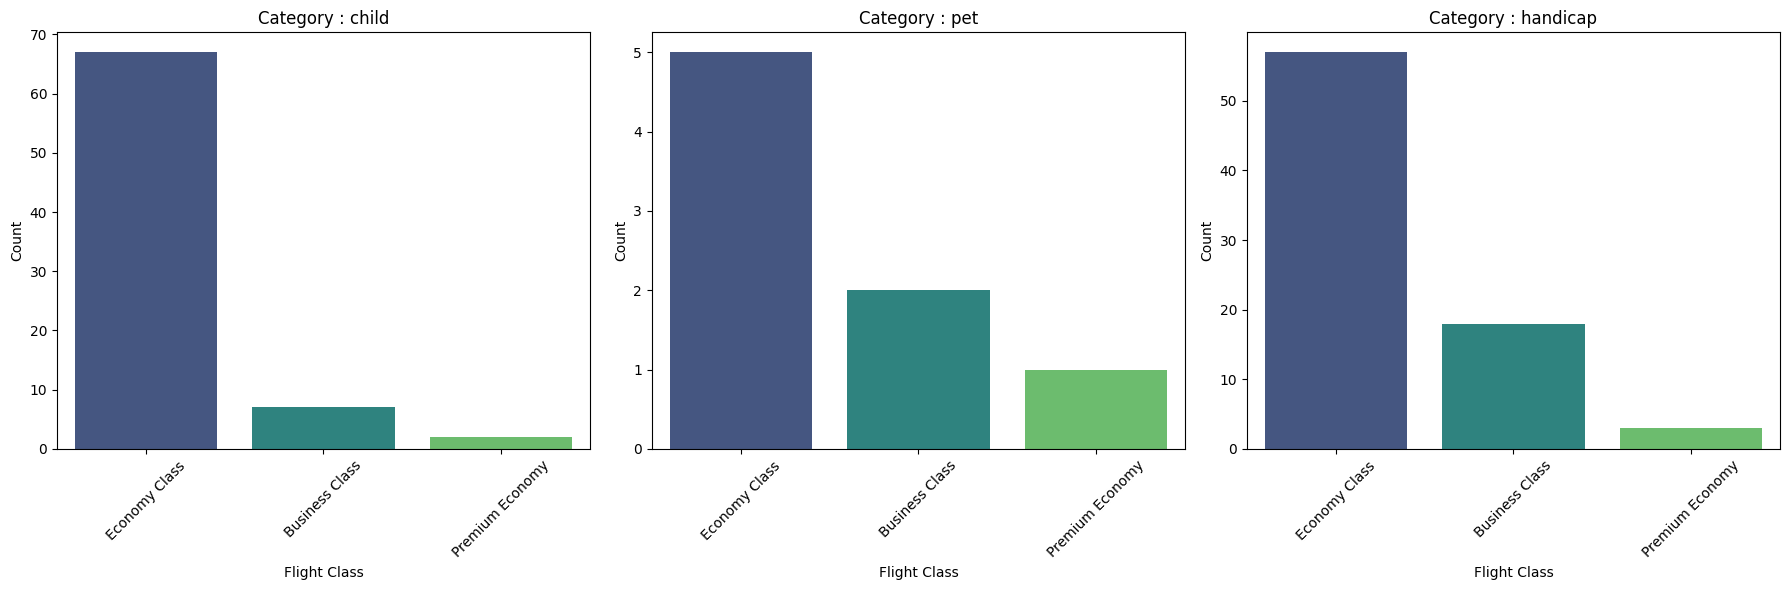

In [301]:
feature = "Class"   

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort("count", descending=True))

    types = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(types))
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Category : {cat}")
    ax.set_xlabel("Flight Class")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## European hotel reviews

In [302]:
df_initial_path = "../../data/original/dataset/data_european_hotel_reviews.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_european_hotel_reviews_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 179 rows for category 'child'
  -> Added 61 rows for category 'pet'
  -> Added 72 rows for category 'handicap'

Final merged DataFrame: 312 rows, 18 cols


### Date

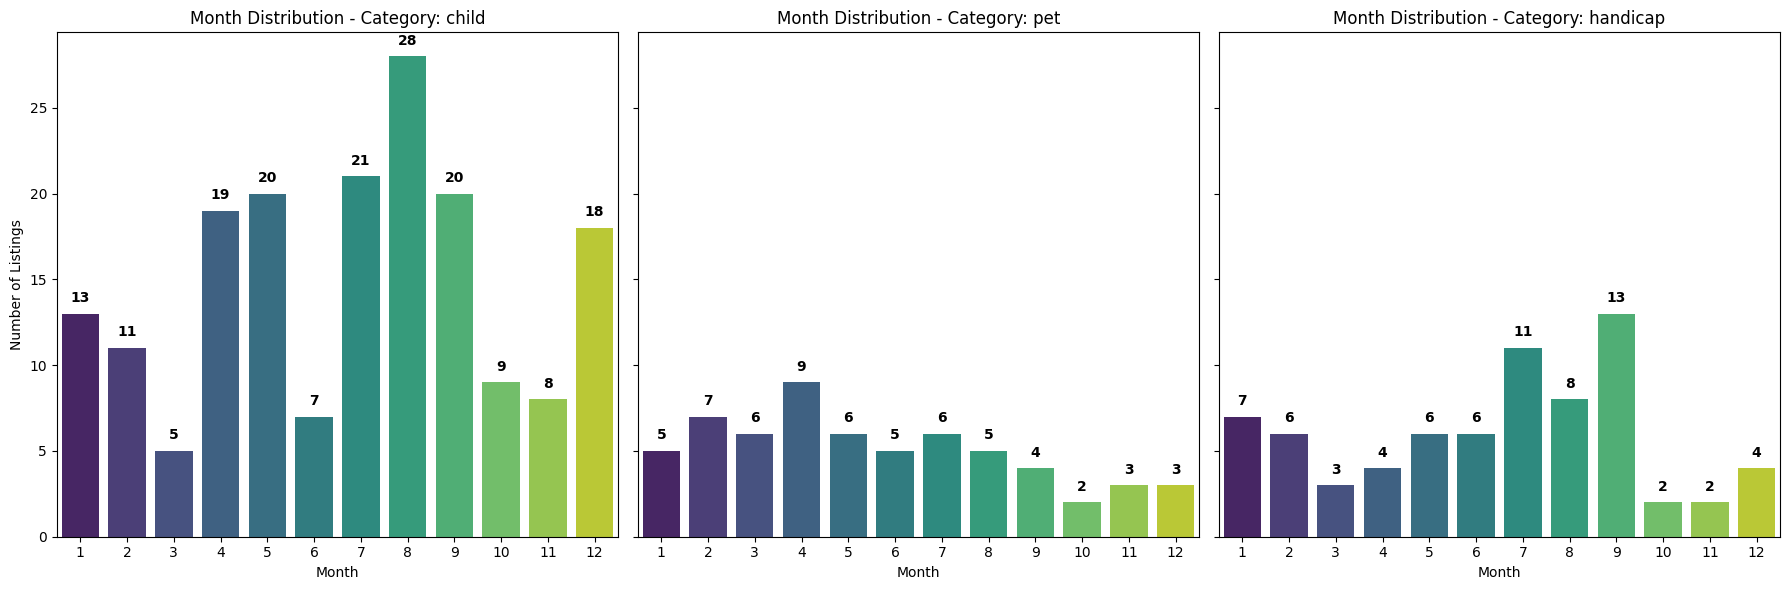

In [303]:
df = df.with_columns(pl.col("Review_Date").str.strptime(pl.Date, format="%m/%d/%Y", strict=False).alias("review_date"))
df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature))
    
    values = counts["count"].to_list()
    labels = counts[feature].to_list()

    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Tags

In [304]:
df = df.with_columns(pl.col("Tags").str.replace_all(r"[\[\]']", "").str.split(",").alias("tags_list"))

def extract_tag_info(tags):
    trip_types = {"Leisure trip", "Business trip"}
    traveller_types = {
        "Family with young children",
        "Family with older children",
        "Group",
        "Couple",
        "Solo traveler"
    }
    trip = traveller = room_str = None
    nights = None

    if not tags:
        return None, None, None, None

    for t in tags:
        t_clean = t.strip()
        if t_clean in trip_types:
            trip = t_clean
        elif t_clean in traveller_types:
            traveller = t_clean
        elif re.match(r"Stayed (\d+) nights", t_clean):
            nights = int(re.findall(r"\d+", t_clean)[0])
        elif "Room" in t_clean:
            room_str = t_clean

    return trip, traveller, room_str, nights


tags_lists = df["tags_list"].to_list()
trip, traveller, room, nights = zip(*[extract_tag_info(tags) for tags in tags_lists])

df = df.with_columns([
    pl.Series("trip_type", trip),
    pl.Series("traveller_type", traveller),
    pl.Series("room_type", room),
    pl.Series("nights", nights)
])


In [305]:
def plot_feature_distribution(df, feature, categories, title):
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

    for ax, cat in zip(axes, categories):
        df_cat = df.filter(pl.col("category") == cat)

        counts = (
            df_cat
            .group_by(feature)
            .agg(pl.len().alias("count"))
            .sort("count", descending=True)
        )

        labels = counts[feature].to_list()
        values = counts["count"].to_list()

        palette = sns.color_palette("viridis", n_colors=len(labels))
        sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
        ax.set_title(f"{title} - {cat}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

        for bar in ax.patches:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.5, str(int(h)),
                    ha="center", va="bottom", fontweight="bold")

    plt.tight_layout()
    plt.show()

#### Type of trip

C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)


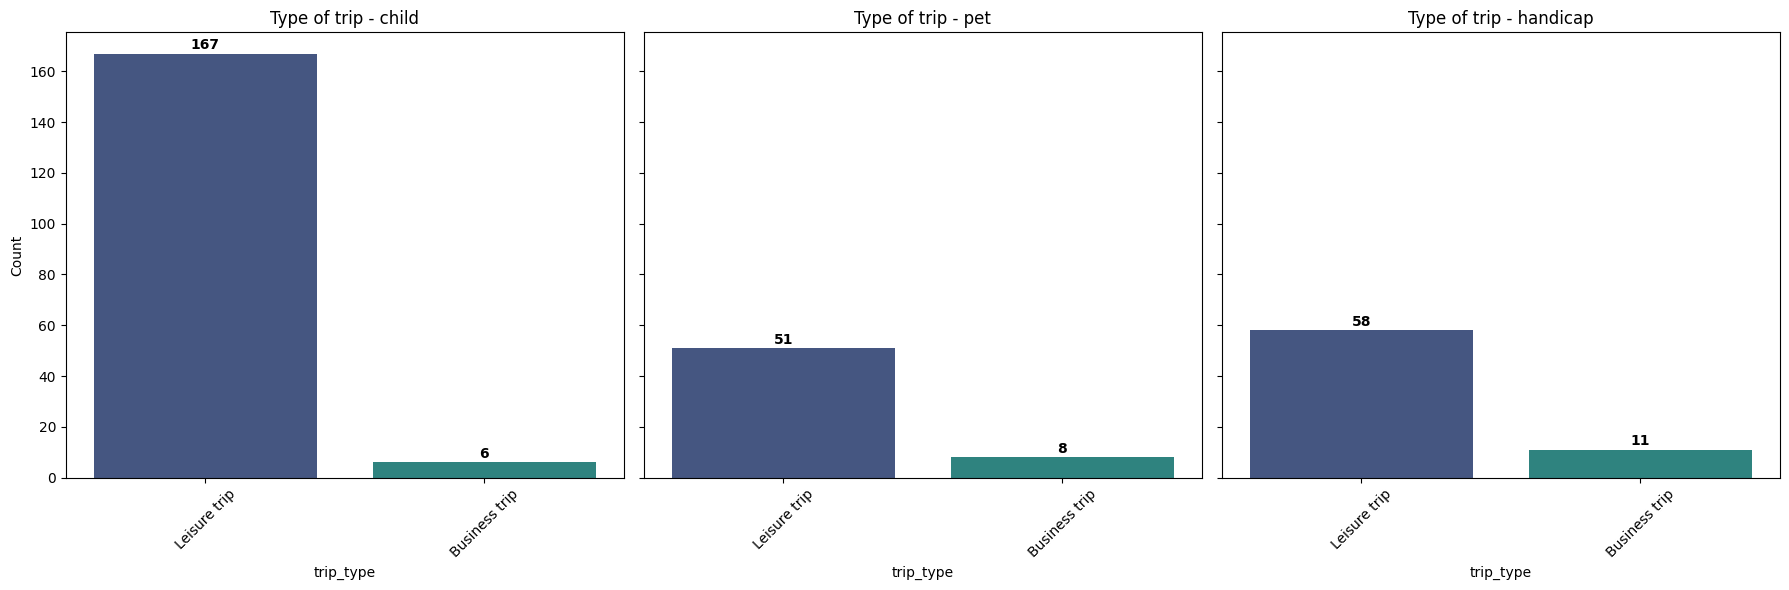

In [306]:
plot_feature_distribution(df, "trip_type", categories, "Type of trip")

#### Type of traveller

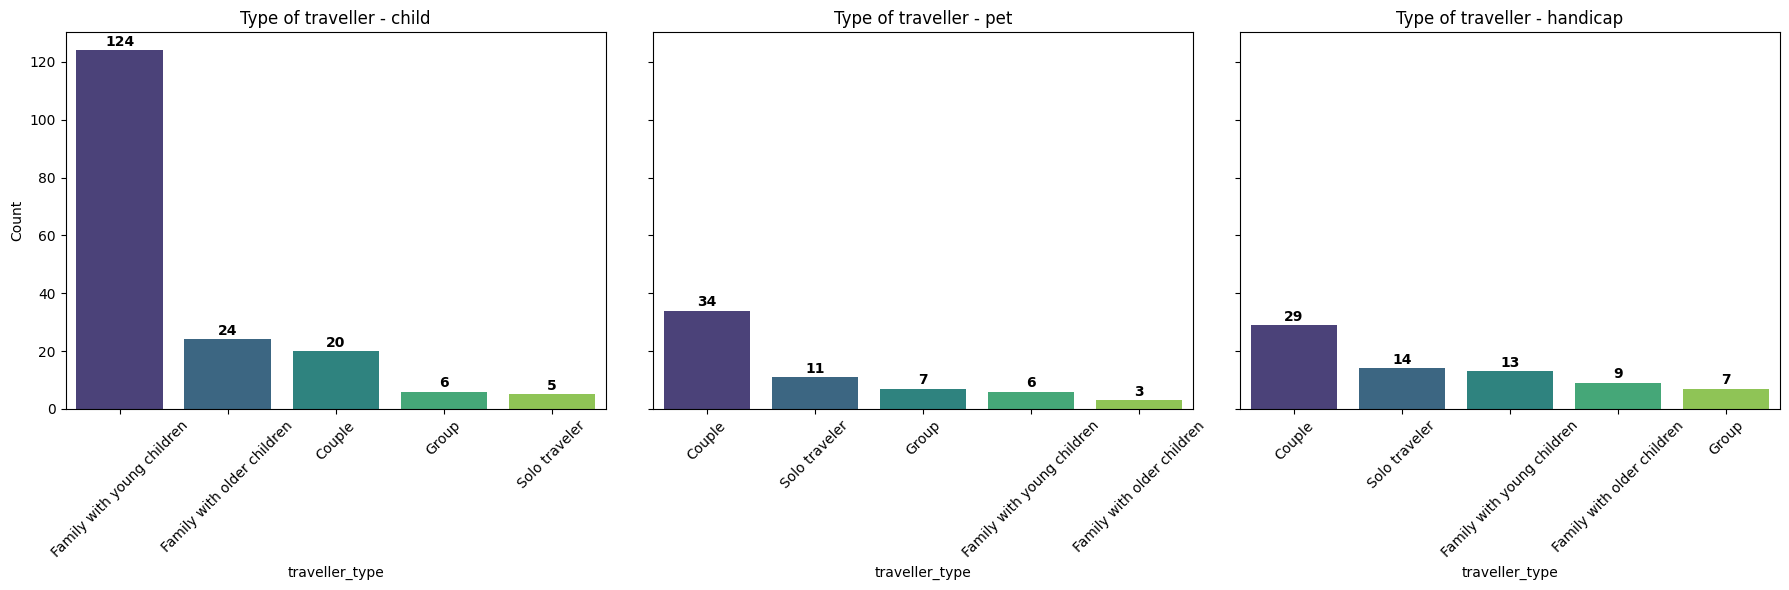

In [307]:
plot_feature_distribution(df, "traveller_type", categories, "Type of traveller")

#### Number of night stayed

C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
C:\Users\emma\AppData\Local\Temp\ipykernel_2536\2174150195.py:18: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)


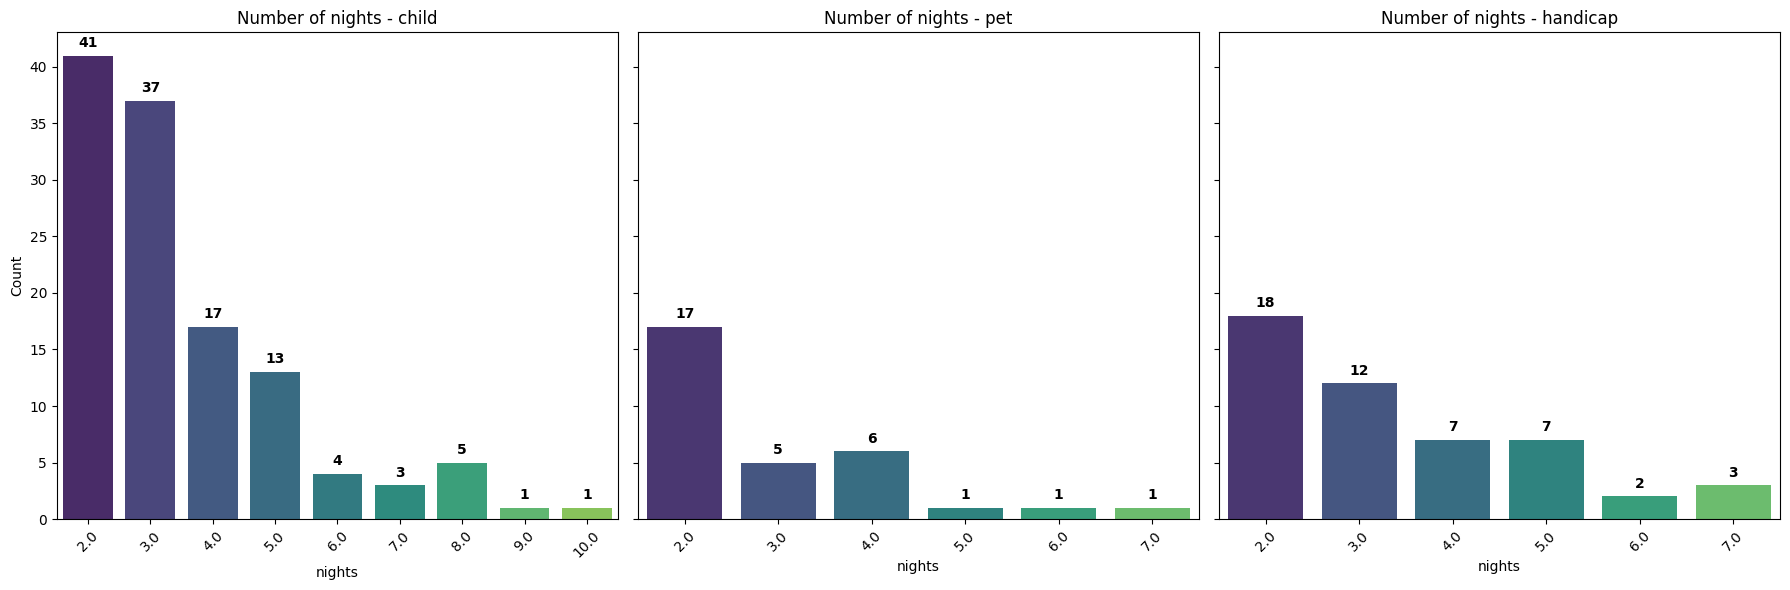

In [308]:
plot_feature_distribution(df, "nights", categories, "Number of nights")

#### Type of room

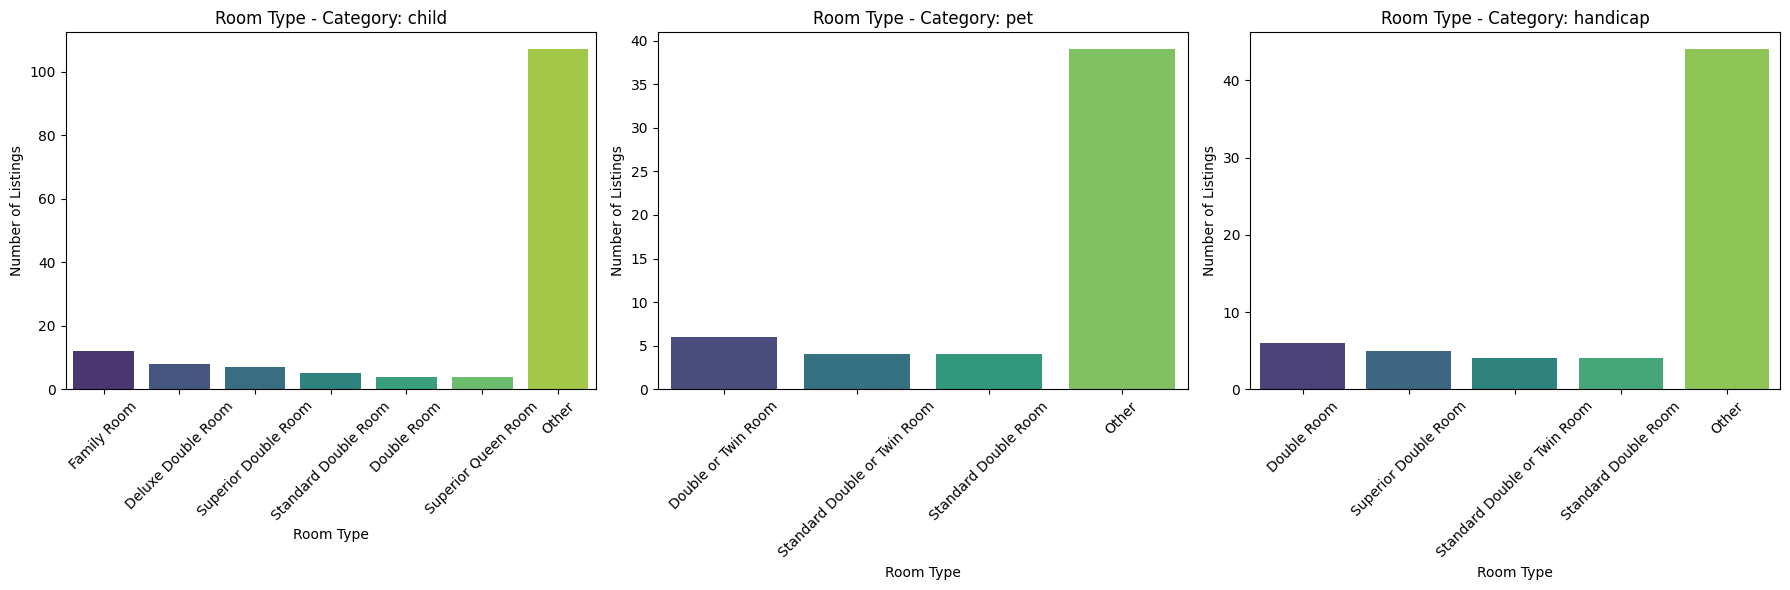

In [309]:
min_other = 4

merge_map = {
    "Hotel": "Hotel",
    "Hotels": "Hotel"
}

df_expanded = (
    df
    .with_columns(pl.col("room_type").str.split(",").alias("room_split"))
    .explode("room_split")             
    .with_columns(pl.col("room_split").str.strip_chars().alias("room_clean"))
)

fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))
for ax, cat in zip(axes, categories):
    df_cat = df_expanded.filter(pl.col("category") == cat)
    df_display = df_cat.with_columns(pl.col("room_clean").map_elements(lambda x: merge_map.get(x, x)).alias("room_display"))
    
    counts = (
        df_display.group_by("room_display")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
    )
    
    frequent_counts = counts.filter(pl.col("count") >= min_other)
    rare_counts = counts.filter(pl.col("count") < min_other)
    other_count = rare_counts["count"].sum()
    
    if other_count > 0:
        other_row = pl.DataFrame({
            "room_display": ["Other"],
            "count": [other_count]
        }).with_columns(pl.col("count").cast(frequent_counts["count"].dtype))
        frequent_counts = pl.concat([frequent_counts, other_row])

    types = frequent_counts["room_display"].to_list()
    values = frequent_counts["count"].to_list()
    
    palette = sns.color_palette("viridis", n_colors=len(types)-1)
    sns.barplot(x=types, y=values, hue=types, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Room Type - Category: {cat}")
    ax.set_xlabel("Room Type")
    ax.set_ylabel("Number of Listings")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Localization

In [310]:
coords = list(zip(df['lat'].to_list(), df['lng'].to_list()))
coords_valid = [(lat, lng) for lat, lng in coords if lat is not None and lng is not None]

results = rg.search(coords_valid)  

df_geo = pd.DataFrame(coords_valid, columns=['lat', 'lng'])
df_geo['country'] = [res['cc'] for res in results]
df_pd = df.to_pandas()
df_merged = df_pd.merge(df_geo, how='left', on=['lat', 'lng'])

gdf = gpd.GeoDataFrame(df_merged, geometry=gpd.points_from_xy(df_merged['lng'], df_merged['lat']))

In [311]:
def plot_country_distribution_pandas(df, feature="country", categories=None, title="Country Distribution", min_other=5, merge_map=None):

    if categories is None:
        categories = df['category'].unique()

    fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)

    for ax, cat in zip(axes, categories):
        df_cat = df[df['category'] == cat].copy()

        if merge_map:
            df_cat[feature + "_display"] = df_cat[feature].map(lambda x: merge_map.get(x, x))
            display_col = feature + "_display"
        else:
            display_col = feature

        counts = df_cat[display_col].value_counts().reset_index()
        counts.columns = [display_col, "count"]

        frequent_counts = counts[counts['count'] >= min_other]
        rare_counts = counts[counts['count'] < min_other]
        other_count = rare_counts['count'].sum()

        if other_count > 0:
            other_row = pd.DataFrame({display_col: ["Other"], "count": [other_count]})
            frequent_counts = pd.concat([frequent_counts, other_row], ignore_index=True)

        labels = frequent_counts[display_col].tolist()
        values = frequent_counts["count"].tolist()

        palette = sns.color_palette("viridis", n_colors=len(labels))
        sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
        ax.set_title(f"{title} - {cat}")
        ax.set_xlabel("Country")
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

        for i, v in enumerate(values):
            ax.text(i, v + 0.5, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

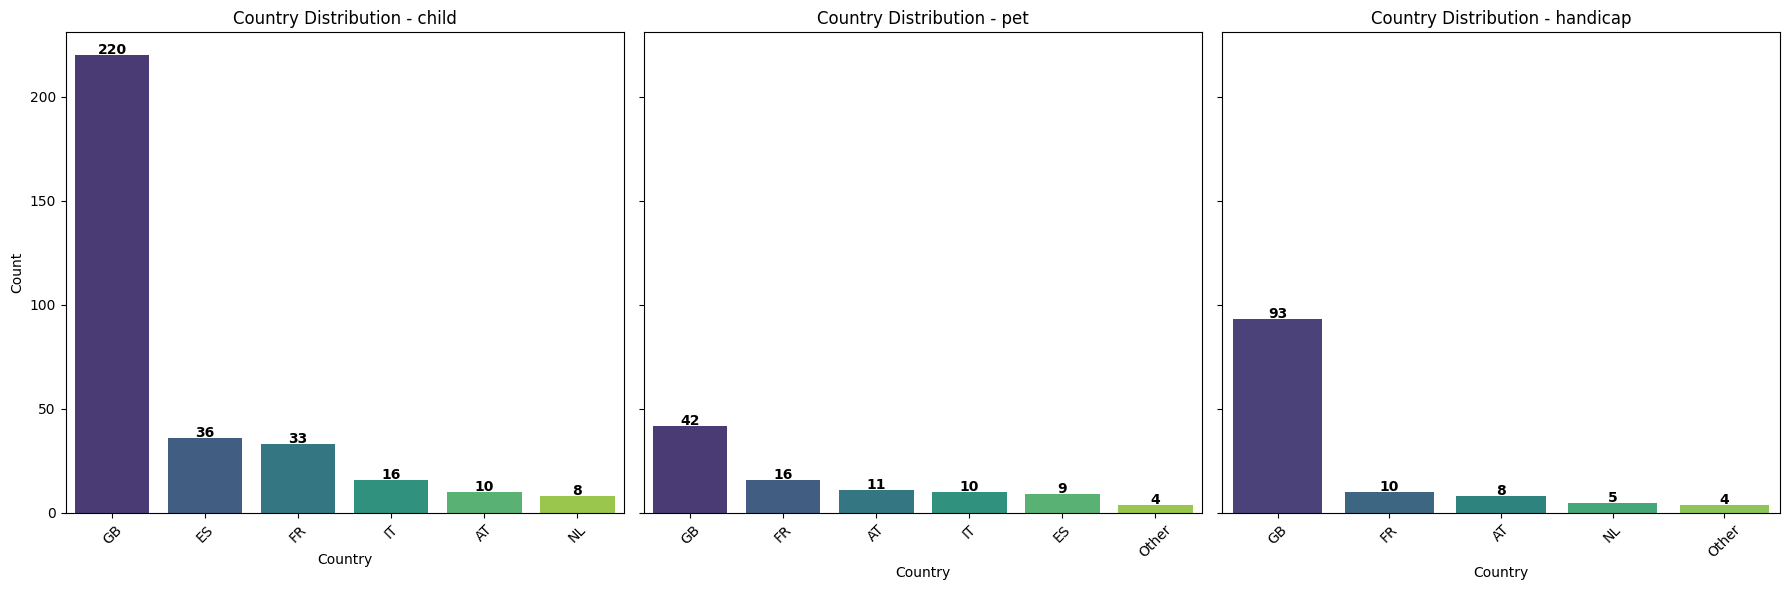

In [312]:
categories = df_merged['category'].unique()
merge_map = {"United States": "USA", "United Kingdom": "UK"}

plot_country_distribution_pandas(df_merged, feature="country", categories=categories, min_other=5, merge_map=merge_map)


## Restaurant reviews 2

In [313]:
df_initial_path = "../../data/original/dataset/data_restaurant_reviews_2.csv"
df_final_path_template = "../../data/processed/final/{category}/validated_data_restaurant_reviews_2_{category}_good.csv"

df = build_dataset_from_final_files(
    df_initial_path=df_initial_path,
    df_final_path_template=df_final_path_template,
    categories=categories
)

  -> Added 50 rows for category 'child'
  -> Added 1 rows for category 'pet'
  -> Error reading ../../data/processed/final/handicap/validated_data_restaurant_reviews_2_handicap_good.csv: Le fichier spécifié est introuvable. (os error 2): ..../../data/processed/final/handicap/validated_data_restaurant_reviews_2_handicap_good.csv (set POLARS_VERBOSE=1 to see full path). Skipping this category.

Final merged DataFrame: 51 rows, 10 cols


### Date

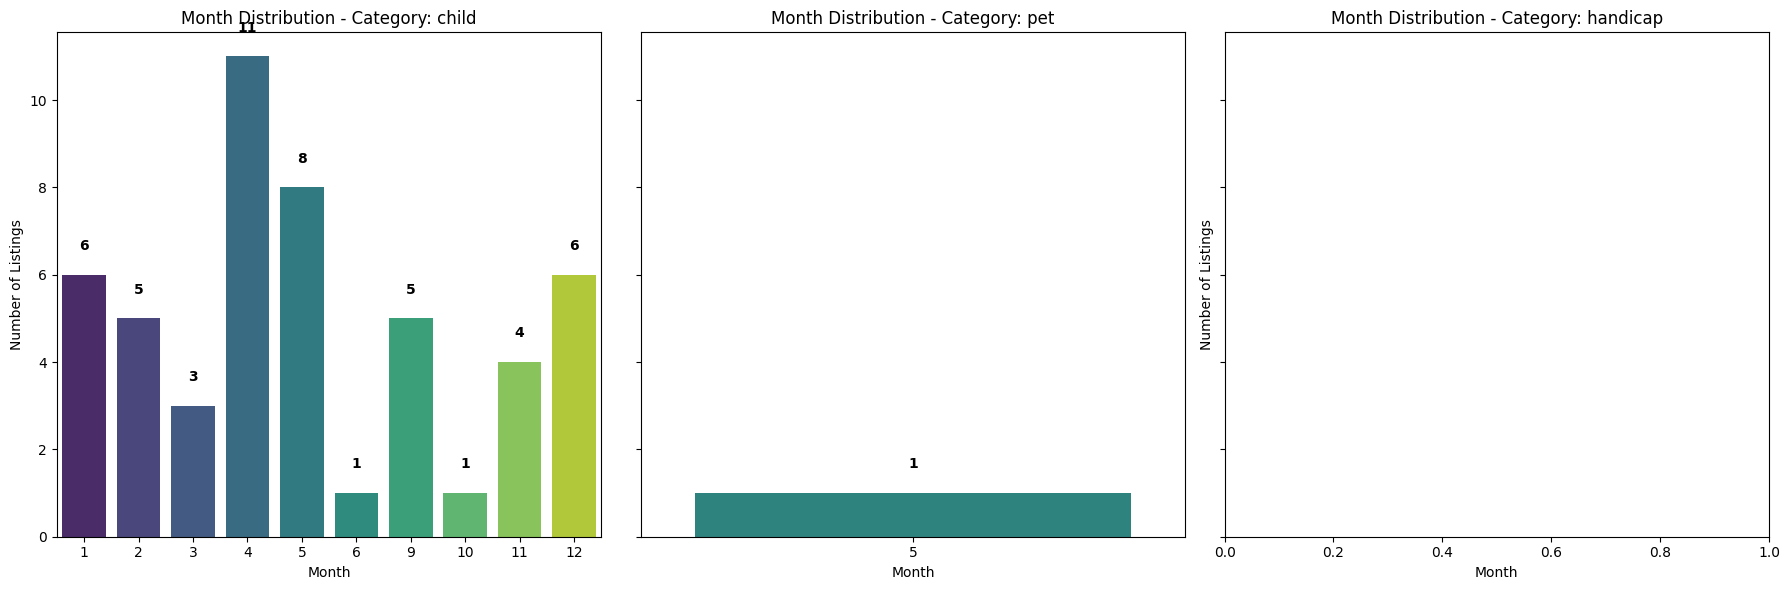

In [314]:
df = df.with_columns(
    pl.col("Time")
      .str.strptime(pl.Datetime, format="%m/%d/%Y %H:%M", strict=False)
      .alias("review_date")
)

df = df.with_columns(pl.col("review_date").dt.month().alias("month"))

feature = "month"
fig, axes = plt.subplots(1, len(categories), figsize=(18, 6), sharey=True)
for ax, cat in zip(axes, categories):
    df_cat = df.filter(pl.col("category") == cat)
    counts = (df_cat.group_by(feature).agg(pl.len().alias("count")).sort(feature))

    labels = counts[feature].to_list()
    values = counts["count"].to_list()

    palette = sns.color_palette("viridis", n_colors=len(labels))
    sns.barplot(x=labels, y=values, hue=labels, palette=palette, legend=False, ax=ax)
    ax.set_title(f"Month Distribution - Category: {cat}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of Listings")
    
    for i, v in enumerate(values):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
